# Food Hazard Detection Challenge

The **Food Hazard Detection Challenge** involves predicting two key categories, **hazard-category** and **product-category**, based on the provided dataset. The objective is to evaluate and compare machine learning models using both short-text (title) and long-text (text) features for accurate classification. Below is a description of the dataset and analysis tasks.

---

## Dataset Overview

This project performs multi-label classification on text data using machine learning algorithms. It includes:
- **Data preprocessing**: Loading and cleaning text data, feature extraction using TF-IDF.
- **Model Building**: Training multiple classification algorithms (e.g., Logistic Regression, Decision Trees, SVM).
- **Hyperparameter Tuning**: Using GridSearchCV/RandomizedSearchCV to optimize hyperparameters.
- **Model Evaluation**: Evaluating model performance using metrics like precision, recall, F1-score, and AUC-ROC.
- **Model Comparison**: Comparing the results of different models.
- **Visualization**: Plotting evaluation metrics for easy comparison.


The dataset includes the following columns:

| **Column Name**       | **Description**                                                                                           |
|------------------------|-----------------------------------------------------------------------------------------------------------|
| `year`                | The year of the recall notification.                                                                     |
| `month`               | The month of the recall notification.                                                                    |
| `day`                 | The day of the recall notification.                                                                      |
| `country`             | The country issuing the recall.                                                                          |
| `title`               | A short description or title of the recall notification.                                                 |
| `text`                | Detailed information about the recall, including product name, problem description, and quantities.      |
| `hazard-category`     | The general category of the hazard (e.g., *biological*, *chemical*).                                      |
| `product-category`    | The general category of the product (e.g., *meat, egg and dairy products*).                               |
| `hazard`              | The specific hazard associated with the product (e.g., *listeria monocytogenes*).                        |
| `product`             | The specific product involved in the recall (e.g., *smoked sausage*).                                    |

---

## Task Description

### Objective:
The goal is to develop machine learning models that predict the **product-category** and **hazard-category** using:
1. **Short Texts (Title)**: Analyze the predictive power of concise information.
2. **Long Texts (Text)**: Leverage detailed descriptions for enhanced accuracy.

### Steps to Perform:
1. **Data Preprocessing**:
   - Tokenize and preprocess the `title` and `text` columns.
   - Perform stopword removal, lemmatization, or stemming.
   - Use techniques like **TF-IDF** to convert text data into numerical representations.

2. **Model Training**:
   - Train separate models for the `title` and `text` data using various machine learning algorithms.
   - Explore both basic (e.g., Logistic Regression, Naive Bayes) and advanced (e.g., Random Forest, Gradient Boosting) models.

3. **Evaluation**:
   - Measure performance using metrics such as **accuracy**, **precision**, **recall**, and **F1-score**.
   - Compare results to determine which approach (short-text vs. long-text) provides better predictions.

4. **Submission**:
   - Submit predictions to the leaderboard for evaluation.
   - Document the results, including the best-performing model, and report the score and rank.

---

## Exploratory Data Analysis

### Sample Data:
Below is a preview of the dataset:

| Year | Month | Day | Country | Title                          | Text                                                                                                                        | Hazard-Category | Product-Category     | Hazard                 | Product        | 
|------|-------|-----|---------|--------------------------------|------------------------------------------------------------------------------------------------------------------------------------|-----------------|----------------------|------------------------|----------------|
| 1994 | 1     | 7   | US      | Recall Notification: FSIS-024-94 | Case Number: 024-94; Date Opened: 07/01/1994; Date Closed: 09/22/1994; Recall Class: 1; Press Release: Y; Product: SMOKED CHICKEN SAUSAGE; Problem: BACTERIA; Description: LISTERIA; Total Pounds Recalled: 2,894; Pounds Recovered: 2,894 | Biological     | Meat, egg and dairy  | Listeria monocytogenes | Smoked Sausage |
| 1994 | 3     | 10  | US      | Recall Notification: FSIS-033-94 | Case Number: 033-94; Date Opened: 10/03/1994; Date Closed: 01/19/1995; Recall Class: 1; Press Release: Y; Product: WIENERS; Problem: BACTERIA; Description: LISTERIA; Total Pounds Recalled: 5,500; Pounds Recovered: 4,568              | Biological     | Meat, egg and dairy  | Listeria spp           | Sausage        |

### Key Insights:
- The dataset contains structured fields for date and location, and unstructured text fields (`title`, `text`).
- Labels (`hazard-category`, `product-category`) are categorical, ideal for classification tasks.
- The `text` column provides significantly more details compared to the `title`, which may result in better predictive performance.

---

## Benchmarking Approaches

1. **Short Text Analysis (Title)**:
   - Focus on extracting features from the `title` column.
   - Use simple & advanced models to test the power of concise recall descriptions.

2. **Long Text Analysis (Text)**:
   - Utilize the detailed information in the `text` column.
   - Apply simple & advanced feature extraction and machine learning techniques to maximize prediction accuracy.


**This approach ensures a comprehensive evaluation of the dataset and provides insights into the predictive power of short vs. long textual descriptions for food hazard detection.**


---
## Libraries and Their Usage

**Essential Libraries for Data Analysis and Machine Learning**

   1. **`pandas`**: A powerful data manipulation and analysis library. It provides data structures such as DataFrames for handling structured data.
   2. **`IPython.display`**: A module that enables displaying rich media outputs such as HTML, images, and data frames within Jupyter notebooks.
   3. **`re`**: A library for working with regular expressions, useful for text processing tasks like pattern matching.

---

**Natural Language Processing (NLP) Tools**  

   1. **`nltk`**: The Natural Language Toolkit, used for working with human language data. It provides tools for tokenization, lemmatization, stemming, and more.
   2. **`stopwords`**: Part of the `nltk.corpus`, contains a list of commonly used words (like 'the', 'and', etc.) that can be removed from text during preprocessing.
   3. **`wordnet` (as `wn`)**: A lexical database for the English language, used for finding synonyms, antonyms, definitions, and semantic relationships between words.
   4. **`word_tokenize`**: A function from `nltk.tokenize` that splits text into individual words (tokens).
   5. **`WordNetLemmatizer`**: Part of `nltk.stem`, used for lemmatizing words based on their meanings, converting words to their base form.

---

**Text Feature Extraction**

   1. **`sklearn.feature_extraction.text.TfidfVectorizer`**: A tool for converting text data into numerical feature vectors, using the Term Frequency-Inverse Document Frequency method, commonly used in text classification.

---

**Machine Learning Libraries and Models**

   1. **`sklearn.linear_model.LogisticRegression`**: A model for binary and multiclass classification based on the logistic regression algorithm.
   2. **`sklearn.tree.DecisionTreeClassifier`**: A model that uses decision trees for classification, splitting data based on feature values.
   3. **`sklearn.naive_bayes.MultinomialNB`**: A Naive Bayes classifier that works well for text classification problems.
   4. **`sklearn.ensemble.RandomForestClassifier`**: A model based on an ensemble of decision trees, designed to improve classification performance.
   5. **`sklearn.ensemble.GradientBoostingClassifier`**: A model that builds an additive model by fitting new trees to residuals of previous trees, used for boosting performance.
   6. **`sklearn.svm.SVC`**: A Support Vector Classifier for classification tasks, particularly effective for high-dimensional data.
   7. **`sklearn.neural_network.MLPClassifier`**: A multi-layer perceptron classifier, a type of neural network for classification tasks.

 ---

**Utility Modules for Model Training, Tuning, and Preprocessing**

   1. **`sklearn.model_selection.train_test_split`**:
   A utility to split data into training and testing sets, ensuring the model is evaluated properly.
   2. **`sklearn.multioutput.MultiOutputClassifier`**:
   A method for fitting multiple classifiers for multi-output tasks, allowing prediction of multiple target variables.
   3. **`sklearn.feature_extraction.text.TfidfVectorizer`**:
   A method for converting text data into numerical features using term frequency-inverse document frequency (TF-IDF).
   4. **`sklearn.model_selection.GridSearchCV`**:
   Performs exhaustive search over specified hyperparameter values for a given model.
   5. **`sklearn.model_selection.RandomizedSearchCV`**:
   Randomized search over hyperparameter values to find optimal settings, often more efficient than grid search for large parameter spaces.
   6. **`sklearn.pipeline.Pipeline`**:
   Allows for chaining preprocessing steps and model fitting into a single workflow.

---

**Evaluation and Scoring Metrics**

   1. **`sklearn.metrics.accuracy_score`**:
    Measures the proportion of correct predictions.
   2. **`sklearn.metrics.classification_report`**:
   Provides a detailed report on classification metrics, such as precision, recall, and F1-score.
   3. **`sklearn.metrics.f1_score`**:
   Combines precision and recall into a single metric, suitable for imbalanced datasets.
   4. **`sklearn.metrics.precision_score`**:
   Measures the proportion of true positives out of all predicted positives.
   5. **`sklearn.metrics.recall_score`**:
    Measures the proportion of true positives out of all actual positives.
   6. **`sklearn.metrics.roc_curve` and `auc`**:
   Used to calculate and plot the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) score, indicating a model's ranking ability.

---

**Additional Libraries**

   1. **`sklearn.exceptions.UndefinedMetricWarning`**:
   Handles warnings when a metric cannot be defined (e.g., no positive predictions).
   2. **`sklearn.preprocessing.LabelBinarizer`**:
   Converts categorical labels into a binary format, useful for multi-class classification.
   3. **`matplotlib.pyplot`**:
   Used for plotting data and visualizing results, such as ROC curves and feature importance.
   4. **`seaborn`**:
   A statistical data visualization library that builds on matplotlib, offering a high-level interface for drawing attractive graphs.
   5. **`numpy`**:
   A library for numerical computing, often used for handling arrays and matrix operations.
   6. **`warnings`**:
   Allows for filtering and managing warnings generated during the execution of the code.
---

# Section 1: Data Preprocessing

In [4]:
import pandas as pd
from IPython.display import display
import re

In [5]:
pd.set_option('display.max_rows', None)       # Show all rows
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.max_colwidth', None)   # Display full width of each cell
pd.set_option('display.width', None)          # Increase display width
pd.set_option('display.colheader_justify', 'left')        

In [ ]:
file = pd.read_csv(r'C:/Users/maria/Desktop/incidents_train.csv')
filen = file.drop(file.columns[0], axis=1)

In [ ]:
def clean(text):
    # Remove text inside angle brackets, e.g., <...>
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\n', ' ', text)
    return text

filen['new_text'] = filen['text'].apply(clean)

In [11]:
file_copy = filen.copy()  # Create a copy of the original DataFrame, in order not to lose the initial one!!!

# Replace the 'text' column in the copied DataFrame with 'new_text'
file_copy['text'] = file_copy['new_text']  
file_copy.drop(file_copy.columns[len(file_copy.columns) - 1], inplace=True, axis=1)
display(file_copy[['text', 'title', 'hazard-category', 'product-category' ,'hazard', 'product']].head(3))

,text,title,hazard-category,product-category,hazard,product
0,"Case Number: 024-94 Date Opened: 07/01/1994 Date Closed: 09/22/1994 Recall Class: 1 Press Release (Y/N): Y Domestic Est. Number: 05893 P Name: GERHARD'S NAPA VALLEY SAUSAGE Imported Product (Y/N): N Foreign Estab. Number: N/A City: NAPA State: CA Country: USA Product: SMOKED CHICKEN SAUSAGE Problem: BACTERIA Description: LISTERIA Total Pounds Recalled: 2,894 Pounds Recovered: 2,894",Recall Notification: FSIS-024-94,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,"Case Number: 033-94 Date Opened: 10/03/1994 Date Closed: 01/19/1995 Recall Class: 1 Press Release (Y/N): Y Domestic Est. Number: 05600 M Name: WIMMER'S MEAT PRODUCTS Imported Product (Y/N): N Foreign Estab. Number: N/A City: WEST POINT State: NE Country: USA Product: WIENERS Problem: BACTERIA Description: LISTERIA Total Pounds Recalled: 5,500 Pounds Recovered: 4,568",Recall Notification: FSIS-033-94,biological,"meat, egg and dairy products",listeria spp,sausage
2,"Case Number: 014-94 Date Opened: 03/28/1994 Date Closed: 07/19/1994 Recall Class: 1 Press Release (Y/N): Y Domestic Est. Number: 00819 M Name: WILLOW FOODS INC Imported Product (Y/N): N Foreign Estab. Number: N/A City: FALLS CITY State: NE Country: USA Product: HAM, SLICED Problem: BACTERIA Description: LISTERIA Total Pounds Recalled: 3,950 Pounds Recovered: 3,809",Recall Notification: FSIS-014-94,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices


In [9]:
# Display the number of unique categories in each column
print("Unique categories in 'product-category':", file_copy['product-category'].nunique())
print("Unique categories in 'hazard-category':", file_copy['hazard-category'].nunique())
print("Unique hazards in 'hazard':", file_copy['hazard'].nunique())
print("Unique products in 'product':", file_copy['product'].nunique())

Unique categories in 'product-category': 22
Unique categories in 'hazard-category': 10
Unique hazards in 'hazard': 128
Unique products in 'product': 1022


In [10]:
# Display unique values with formatting
print("Unique categories in 'product-category':")
print(file_copy['product-category'].unique().tolist())

print("\nUnique categories in 'hazard-category':")
print(file_copy['hazard-category'].unique().tolist())

print("\nUnique hazards in 'hazard':")
print(file_copy['hazard'].unique().tolist())

print("\nUnique products in 'product':")
print(file_copy['product'].unique().tolist())


Unique categories in 'product-category':
['meat, egg and dairy products', 'prepared dishes and snacks', 'cereals and bakery products', 'confectionery', 'ices and desserts', 'alcoholic beverages', 'fruits and vegetables', 'other food product / mixed', 'cocoa and cocoa preparations, coffee and tea', 'nuts, nut products and seeds', 'seafood', 'soups, broths, sauces and condiments', 'fats and oils', 'non-alcoholic beverages', 'food contact materials', 'dietetic foods, food supplements, fortified foods', 'herbs and spices', 'food additives and flavourings', 'sugars and syrups', 'honey and royal jelly', 'feed materials', 'pet feed']

Unique categories in 'hazard-category':
['biological', 'foreign bodies', 'chemical', 'fraud', 'organoleptic aspects', 'allergens', 'packaging defect', 'other hazard', 'food additives and flavourings', 'migration']

Unique hazards in 'hazard':
['listeria monocytogenes', 'listeria spp', 'plastic fragment', 'escherichia coli', 'antibiotics, vet drugs', 'sulfamethaz

In [14]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize stemmer and lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'\W', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_tokens]
    return ' '.join(lemmatized_tokens)

# Apply preprocessing to relevant columns
file_copy['processed_title'] = file_copy['title'].apply(preprocess_text)
file_copy['processed_long_text'] = file_copy['text'].apply(preprocess_text)

# Display the results
#display(file_copy[['text','processed_long_text','hazard-category', 'product-category' ,'hazard', 'product']].head(3))


# Section 2: Train-Test Splitting and Benchmark Analyses

### 1. **Data Preparation**
The dataset is prepared for training and testing based on two distinct sources: **Titles** and **Texts**.

- **Using Titles**:
  - `X_train`: The `title` column serves as the feature set.
  - `Y_train`: The target variables are `hazard-category` and `hazard`, `product-category` and  `product`.

- **Using Texts**:
  - `X_train`: The `text` column is used as the feature set.
  - `Y_train`: The target variables are `hazard-category` and `hazard` `product-category` and  `product`.

---

### 2. **TF-IDF Vectorization**
To process textual data:
- The `TfidfVectorizer` is employed to convert the text data into numerical feature matrices.
  - **Term Frequency (TF)**: Measures how often a word appears in a document (e.g., the `title` or `text`).
  - **Inverse Document Frequency (IDF)**: Penalizes common words by assigning higher importance to rarer terms.
  - This representation ensures that words appearing frequently across documents but not concentrated in any single document receive higher importance.

---

### 3. **Benchmark Analyses**

#### **Basic Machine Learning Algorithms**
1. **Logistic Regression**:
   - A simple and effective linear model for classification.
   - Suitable for linearly separable data and regularized by default to prevent overfitting.
   - Expected Performance: Reasonable baseline performance for simpler problems.
   
2. **Decision Trees**:
   - Builds a tree structure based on splitting features.
   - Easily interpretable but prone to overfitting if not pruned.
   - Expected Performance: Handles non-linear relationships better than Logistic Regression.

3. **Naive Bayes**:
   - A probabilistic classifier assuming feature independence.
   - Performs well for text classification tasks (e.g., spam filtering).
   - Expected Performance: Effective in text classification; struggles if feature independence is violated.

#### **Advanced Machine Learning Algorithms**
1. **Random Forest**:
   - Combines multiple decision trees to reduce overfitting.
   - Robust for most classification tasks, even with high-dimensional data.
   - Expected Performance: Typically among the best-performing algorithms.

2. **Gradient Boosting**:
   - Builds trees sequentially, correcting errors from the previous ones.
   - Requires careful hyperparameter tuning but offers high accuracy.
   - Expected Performance: Excellent for complex datasets, often outperforming simpler models.

3. **Support Vector Machines (SVM)**:
   - Finds the optimal hyperplane to separate classes.
   - Supports kernel tricks for non-linear problems but can be computationally expensive.
   - Expected Performance: Strong for small- to medium-sized datasets; may struggle with noisy or large data.

4. **Neural Networks (MLPClassifier)**:
   - Multi-layer perceptron (MLP) models non-linear relationships effectively.
   - Requires large datasets and careful tuning.
   - Expected Performance: Excels on complex tasks but may not outperform simpler models on smaller datasets.

---

### 4. **Expected Outcomes**
- **Best-performing models**:
  - Random Forest and Gradient Boosting are expected to deliver robust results due to their ensemble nature.
- **Text Data**:
  - Naive Bayes is effective for text classification.
- **Simple or Linear Data**:
  - Logistic Regression and Decision Trees are suitable for smaller or simpler datasets.

---

### 5. **Practical Considerations**
- **Tuning**:
  - Advanced models like Gradient Boosting and Neural Networks require hyperparameter optimization for optimal performance.
- **Training Time**:
  - Simpler models (e.g., Logistic Regression, Decision Trees) are faster to train than advanced models like SVM or Neural Networks.
---

# Explanation of the Code

### 1. **Feature and Target Definition**
- **Feature (`X`)**: The `processed_title/processed_long_text` column is selected as the input for the model.
- **Target (`y`)**: Two output columns, `hazard-category` and `product-category`, are selected as the target variables.

### 2. **Train-Test Split**
- The data is split into training and testing sets using `train_test_split` with **80% for training and 20% for testing**. The random state ensures reproducibility.
- The **`random_state`** parameter ensures that the data split is reproducible each time the code is run. Specifically, the `random_state` controls the randomness of the split, meaning that the same split can be achieved each time the code is executed with the same value for `random_state`.

### 3. **TF-IDF Vectorization**
- A `TfidfVectorizer` is initialized with the following parameters:
  - **`max_features=3000`**: Limits the vectorizer to use only the top 3000 features (words) based on their importance across the dataset.
  - This ensures the model focuses on the most relevant features and reduces dimensionality for efficiency.
- The vectorizer:
  - **Fits and transforms** the training data to create numerical representations.
  - **Transforms** the test data using the same vocabulary learned from the training data.
- The resulting sparse matrix is converted to a DataFrame for better visualization, with columns corresponding to the extracted features (words).

### 4. **Evaluation of Algorithms**
- The `evaluate_algorithms` function:
  - Accepts a dictionary of algorithms, the training data (`X_train`, `y_train`), and the test data (`X_test`, `y_test`).
  - Wraps each algorithm with `MultiOutputClassifier` to handle the multi-target nature of the problem (two output columns).
  - Trains the model using the training data and predicts the targets on the test data.
  - Evaluates each model for:
    - **Accuracy**: Measures how often the predictions are correct for each target.
    - **Classification Report**: Provides metrics such as precision, recall, and F1-score for each target.
- Results:
  - Metrics are stored in DataFrames and pivoted for a clearer comparison of each algorithm's performance across the targets.

### 5. **Types of Accuracy, Recall, Precision, and F1-Score**
The classification metrics are computed for each target column, and their types include:

#### **Accuracy**
-Accuracy is the fraction of the correctly classified instances in our sample. Shows how often a classification ML model is correct overall.

$$ Accuracy = (1 - Error Rate) = \frac{TP+TN}{TP+FP+TN+FN} $$
- Downside:
   -  It treats all classes as equally important and looks at all correct predictions. 

#### **Precision**
- Measures the proportion of positive predictions that are actually correct. Shows how often an ML model is correct when predicting the target class.
 
$$ P = \frac{TP}{TP+FP} $$

#### **Recall**
- Measures the proportion of actual positives that are correctly predicted.  Shows whether an ML model can find all objects of the target class.
 
$$ R = \frac{TP}{TP + FN} $$

#### **F1-Score**
- The harmonic mean of precision and recall, balancing their trade-off.

$$ F_1 = \frac{P \cdot R}{ P + R}$$
- Where:
    - \(P\) is **Precision**.
    - \(R\) is **Recall**.


### **Macro, Micro, and Weighted Averages in Classification**

In classification tasks, **precision**, **recall**, and **F1-score** can be averaged across multiple classes using different methods: **macro**, **micro**, and **weighted** averages. Each method provides different insights into model performance, especially in multi-class and imbalanced datasets.

#### Types of Averages:

1. **Macro Average**
   - **Description**: The metric is computed independently for each class, and then the average is taken across all classes. Each class is treated equally, regardless of the number of samples (support) in that class.
$$
\text{Macro Average} = \frac{1}{N} \sum_{i=1}^{N} \text{Metric}_i
$$
Where:
- \( N \) is the number of classes.
- $ \text{Metric}_i $ is the precision, recall, or F1-score for class \( i \).

   - **Use case**: Use when you care about performance on all classes equally, especially when evaluating performance on smaller classes.

2. **Micro Average**
   - **Description**: This method aggregates the contributions of all classes to compute the average, essentially by summing true positives, false positives, false negatives, and true negatives across all classes.
$$
\text{Micro Average} = \frac{\sum_{i=1}^{N} \text{True Positives}_i}{\sum_{i=1}^{N} (\text{True Positives}_i + \text{False Positives}_i + \text{False Negatives}_i)}
$$
Where:
- \( N \) is the number of classes.
- True Positives, False Positives, and False Negatives are summed across all classes.

   - **Use case**: Use when you want a global view of performance, and especially when class imbalance exists, as it treats the model's overall performance.

3. **Weighted Average**
   - **Description**: Like macro, it computes the metric for each class, but the average is weighted by the support (number of true instances) of each class, making larger classes have more influence on the final metric.
$$
\text{Weighted Average} = \frac{\sum_{i=1}^{N} \text{Support}_i \times \text{Metric}_i}{\sum_{i=1}^{N} \text{Support}_i}
$$   
Where:
- \( N \) is the number of classes.
- $ \text{Support}_i $ is the number of true instances of class \( i \).
- $ \text{Metric}_i $ is the precision, recall, or F1-score for class \( i \).

   - **Use case**: Use when you want to account for class imbalance while still measuring performance across all classes, giving more importance to the larger classes.

#### Comparison of Pros and Cons:

| **Metric**        | **Pros**                                                                 | **Cons**                                                                       |
|-------------------|--------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| **Macro Average** | - Treats all classes equally regardless of size.                         | - Sensitive to class imbalance; smaller classes can overly influence the result. |
|                   | - Useful for detecting poor performance in smaller classes.              | - Poor performance on minority classes can drag down the overall score.        |
| **Micro Average** | - Aggregates metrics across all classes, treating the entire dataset equally. | - Biased towards majority classes, as it aggregates all instances.             |
|                   | - Good for overall performance measure, especially for imbalanced datasets. | - Doesn't show per-class performance, may mask issues with small classes.      |
| **Weighted Average** | - Takes into account both the performance of each class and its support (size). | - Can be biased towards majority classes, masking poor performance in minority classes. |
|                   | - Useful for imbalanced datasets, balancing performance with class distribution. | - Smaller classes might have less impact despite poor performance.             |

#### Summary of When to Use:
- **Macro Average**: Use when you care about the performance across all classes equally, especially to detect poor performance on less frequent classes.
- **Micro Average**: Use for an overall performance measure, especially when class imbalance exists and you don't need per-class performance details.
- **Weighted Average**: Use when you care about how well the model performs on frequent classes, but still want to account for smaller classes in an imbalanced dataset.



### 6. **Purpose**
- This code prepares textual data for machine learning by transforming it into numerical form using TF-IDF.
- It trains and evaluates multiple machine learning models on a multi-target classification problem, providing insights into their performance.
---


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the feature (title) and target (other columns)
X = file_copy['processed_title']  # Input: title column
X_t = file_copy['processed_long_text'] # Input: text column

y = file_copy[['hazard-category', 'product-category', 'hazard', 'product']]  
y_t = file_copy[['hazard-category', 'product-category', 'hazard', 'product']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer for converting text to numerical features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) # ngram_range=(1, 2) : to capture more context and relationships between words.

# Fit and transform the training data, then transform the test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test) 

X_train_tfidf_t = vectorizer.fit_transform(X_train_t)
X_test_tfidf_t = vectorizer.transform(X_test_t)

# Convert the sparse matrix into a DataFrame for better visualization
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df_t = pd.DataFrame(X_train_tfidf_t.toarray(), columns=vectorizer.get_feature_names_out())

### Hyperparameters

- Hyperparameters control the behavior of machine learning algorithms, including regularization, model complexity, and computational efficiency.
- **`param_grids`** defines the search space for hyperparameters for each algorithm.
- GridSearchCV and RandomizedSearchCV use these grids to find the optimal combination of parameters for the task.
---

### What is `param_grids` and What Do the Parameters Mean?

`param_grids` is a dictionary where:
- The **keys** are the names of the algorithms.
- The **values** are dictionaries specifying the hyperparameters for each algorithm and their possible values.

---

#### Explanation of Each Algorithm's Hyperparameters

1. **Logistic Regression**:
   - `"clf__estimator__C"`:
     - Regularization strength (inverse of regularization term).
     - Higher values = weaker regularization, allowing more complex models.
     - Lower values = stronger regularization, preventing overfitting.
   - `"clf__estimator__solver"`:
     - Algorithm used to optimize the model.
     - `"lbfgs"`: Suitable for smaller datasets.
     - `"saga"`: Supports large datasets and handles sparse data well.

2. **Decision Tree**:
   - `"clf__estimator__max_depth"`:
     - Maximum depth of the tree.
     - Limits how deep the tree can grow, controlling overfitting.
     - `None`: Tree grows until all leaves are pure.
   - `"clf__estimator__min_samples_split"`:
     - Minimum number of samples required to split an internal node.
     - Higher values prevent the tree from growing too complex.

3. **Naive Bayes**:
   - No hyperparameters are tuned here because `MultinomialNB` typically does not have tunable hyperparameters.

4. **Random Forest**:
   - `"clf__estimator__n_estimators"`:
     - Number of trees in the forest.
     - More trees usually improve performance but increase computation time.
   - `"clf__estimator__max_depth"`:
     - Maximum depth of each tree (similar to Decision Tree).
   - `"clf__estimator__min_samples_split"`:
     - Minimum number of samples needed for a node to split (similar to Decision Tree).

5. **SVM (Support Vector Machine)**:
   - `"clf__estimator__C"`:
     - Regularization parameter (similar to Logistic Regression).
     - Controls the tradeoff between achieving a low error on training data and generalizing well.
   - `"clf__estimator__kernel"`:
     - The type of kernel function used (e.g., `"linear"`, `"rbf"`, `"poly"`).
     - Determines how the input space is transformed for separating classes.

6. **Neural Network**:
   - `"clf__estimator__hidden_layer_sizes"`:
     - The number of neurons in each hidden layer.
     - Examples:
       - `(100,)`: One hidden layer with 100 neurons.
       - `(50, 50)`: Two hidden layers, each with 50 neurons.
       - `(30, 30, 30)`: Three hidden layers, each with 30 neurons.
   - `"clf__estimator__activation"`:
     - The activation function used in the hidden layers.
     - `"relu"`: Rectified Linear Unit (default for most neural networks).
     - `"tanh"`: Hyperbolic tangent, useful for some datasets.

---

### What GridSearchCV and RandomizedSearchCV Do

#### GridSearchCV:
- **Purpose**: Exhaustively tests every combination of hyperparameters in a predefined grid to find the best-performing configuration.
- **Process**:
  - Takes a list of hyperparameters for a model.
  - Runs the model for every possible combination of the hyperparameters.
  - Evaluates each combination using the defined scoring metric (e.g., F1).
  - Selects the combination that yields the best score.

- **Pros**:
  - Guarantees the best combination within the grid is found.
- **Cons**:
  - Computationally expensive for large grids.

#### RandomizedSearchCV:
- **Purpose**: Randomly samples combinations of hyperparameters from a predefined grid.
- **Process**:
  - Instead of testing every possible combination, it selects a **fixed number of random combinations**.
  - Evaluates each combination and returns the best-performing one.

- **Pros**:
  - Faster and more efficient than GridSearchCV for large grids.
  - Can explore a broader range of values in less time.
- **Cons**:
  - May not find the absolute best combination due to randomness.

---

### Explanation of Estimator and Scoring in GridSearchCV/RandomizedSearchCV

#### Estimator
- In the context of **GridSearchCV** and **RandomizedSearchCV**, the `estimator` defines the machine learning pipeline that will be optimized.
- Here, the `estimator` is a **Pipeline**, which combines:
  1. **`TfidfVectorizer`**:
     - Converts the text data into numerical features using the Term Frequency-Inverse Document Frequency (TF-IDF) technique.
     - This ensures that the text is represented in a way suitable for machine learning algorithms.
  2. **`MultiOutputClassifier`**:
     - Wraps the specific classification algorithm (e.g., Logistic Regression, Decision Tree) to handle multi-label classification problems.
     - Allows the model to predict multiple output labels for each input sample.

#### Scoring Metric
- The `scoring` parameter specifies the metric used to evaluate the performance of the pipeline during hyperparameter tuning.
- Here, the **F1 score** is used as the scoring metric, specifically through a custom implementation, `multioutput_f1_scorer`.
- **Why Use F1 Score?**
  - F1 score is chosen because the task involves **imbalanced datasets**, where some classes are more frequent than others.
  - By balancing **precision** (avoiding false positives) and **recall** (avoiding false negatives), F1 ensures that the model performs well across all labels.
  - The custom implementation ensures that F1 is calculated for each output label individually, and the mean score is used for evaluation.
- **Why Not Use Other Metrics**:
  - **Accuracy**: Does not work well with imbalanced datasets.
  - **AUC-ROC**: While useful, it focuses on ranking predictions rather than their actual correctness for each label.
  - **Precision/Recall Alone**: Each only tells part of the story, whereas F1 combines them into a single metric.

---

In [ ]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.exceptions import UndefinedMetricWarning
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Define basic algorithms
algorithms_basic = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": MultinomialNB(),
}

# Define advanced algorithms
algorithms_advanced = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "Neural Network": MLPClassifier(random_state=42, max_iter=1000)
}

# Define hyperparameter space for each algorithm
param_grids = {
    "Logistic Regression": {
        "clf__estimator__C": [0.1, 1, 10],
        "clf__estimator__solver": ["lbfgs", "saga"]
    },
    "Decision Tree": {
        "clf__estimator__max_depth": [None, 10, 20, 30],
        "clf__estimator__min_samples_split": [2, 5, 10]
    },
    "Naive Bayes": {},  # No hyperparameters for tuning in MultinomialNB
    "Random Forest": {
        "clf__estimator__n_estimators": [50, 100, 200],
        "clf__estimator__max_depth": [None, 10, 20, 30],
        "clf__estimator__min_samples_split": [2, 5, 10]
    },
    "SVM": {
        "clf__estimator__C": [0.1, 1, 10],
        "clf__estimator__kernel": ["linear", "rbf", "poly"]
    },
    "Neural Network": {
        "clf__estimator__hidden_layer_sizes": [(100,), (50, 50), (30, 30, 30)],
        "clf__estimator__activation": ["relu", "tanh"]
    }
}

# Custom F1 scorer for multioutput
def custom_multioutput_f1(y_true, y_pred):
    y_true = y_true.to_numpy() if hasattr(y_true, 'to_numpy') else np.array(y_true)
    y_pred = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else np.array(y_pred)
    f1_scores = [f1_score(y_true[:, i], y_pred[:, i], average='micro') for i in range(y_true.shape[1])]
    return np.mean(f1_scores)

multioutput_f1_scorer = make_scorer(custom_multioutput_f1)

# Function to train and evaluate algorithms
def algorithms_hyperparameter(algorithms, param_grids, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in algorithms.items():
        print(f"\nEvaluating {name}...")

        # Define pipeline
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
            ('clf', MultiOutputClassifier(model, n_jobs=1))
        ])
        
        # Get hyperparameter grid for the algorithm
        param_dist = param_grids.get(name, {})
        
        if not param_dist:  # No hyperparameter tuning
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            # Evaluate each target separately
            target_results = {}
            for i, column in enumerate(y_test.columns):
                target_results[column] = classification_report(y_test[column], y_pred[:, i], output_dict=True)
            results[name] = target_results
            continue

        # Conditional search strategy
        if len(param_dist) * sum(len(v) for v in param_dist.values()) <= 20:
            search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_dist,
                cv=3,
                scoring=multioutput_f1_scorer,
                verbose=2
            )
        else:
            search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_dist,
                n_iter=20,
                cv=3,
                scoring=multioutput_f1_scorer,
                random_state=42,
                verbose=2
            )

        search.fit(X_train, y_train)
        
        print(f"Best Parameters for {name}:", search.best_params_)
    
    return results

# Evaluate basic and advanced algorithms
basic_results = algorithms_hyperparameter(algorithms_basic, param_grids, X_train, y_train, X_test, y_test)
advanced_results = algorithms_hyperparameter(algorithms_advanced, param_grids, X_train, y_train, X_test, y_test)


Evaluating Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END clf__estimator__C=0.1, clf__estimator__solver=lbfgs; total time=  12.3s
[CV] END clf__estimator__C=0.1, clf__estimator__solver=lbfgs; total time=  13.5s
[CV] END clf__estimator__C=0.1, clf__estimator__solver=lbfgs; total time=  11.4s
[CV] END .clf__estimator__C=0.1, clf__estimator__solver=saga; total time=   4.9s
[CV] END .clf__estimator__C=0.1, clf__estimator__solver=saga; total time=   5.8s
[CV] END .clf__estimator__C=0.1, clf__estimator__solver=saga; total time=   3.8s
[CV] END ..clf__estimator__C=1, clf__estimator__solver=lbfgs; total time=  16.8s
[CV] END ..clf__estimator__C=1, clf__estimator__solver=lbfgs; total time=  16.3s
[CV] END ..clf__estimator__C=1, clf__estimator__solver=lbfgs; total time=  17.9s
[CV] END ...clf__estimator__C=1, clf__estimator__solver=saga; total time=  14.9s
[CV] END ...clf__estimator__C=1, clf__estimator__solver=saga; total time=  15.5s
[CV] END ...cl

### Differences Between `evaluate_algorithms` and `evaluate_models`

#### **1. Purpose and Focus**

- **`evaluate_algorithms`:**
  - Designed to evaluate multiple algorithms on multi-output classification problems.
  - Focuses on returning comprehensive evaluation metrics in the form of pivoted DataFrames (e.g., accuracies, precision, recall, F1-score).

- **`evaluate_models`:**
  - Similar functionality but provides a more detailed and verbose breakdown of metrics for each output class individually.
  - Generates and prints classification reports directly for better interpretability during execution.

---

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

def evaluate_algorithms(algorithms, X_train, y_train, X_test, y_test):
    # Initialize lists to store results
    accuracy_results = []
    classification_results = []
    best_estimators = {} # Dictionary to store the best estimators
    best_model = None  # To track the best model
    best_score = -float('inf')  # Initialize best score to a very low number

    # Loop through each algorithm and evaluate performance
    for algorithm_name, model in algorithms.items():
        print(f"\nTraining and evaluating {algorithm_name}...\n")
        
        # Wrap the model with MultiOutputClassifier if necessary (for multi-output labels)
        multi_target_model = MultiOutputClassifier(model, n_jobs=1)
        
        # Train the model
        multi_target_model.fit(X_train, y_train)

        # Predict on the test data
        y_pred = multi_target_model.predict(X_test)

        
        # Evaluate the model performance for each output column
        total_f1_score = 0  # Initialize total F2 score for the current model

        # Store accuracies for each algorithm and each target column
        for i, column in enumerate(y_test.columns):
            accuracy = round(accuracy_score(y_test[column], y_pred[:, i]), 3)
            accuracy_results.append({
                'Algorithm': algorithm_name,
                'Target': column,
                'Accuracy': accuracy
            })

            # Compute classification metrics
            precision = precision_score(y_test[column], y_pred[:, i], average='macro', zero_division=1)
            recall = recall_score(y_test[column], y_pred[:, i], average='macro', zero_division=1)
            f1 = f1_score(y_test[column], y_pred[:, i], average='macro', zero_division=1)

            classification_results.append({
                'Algorithm': algorithm_name,
                'Target': column,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })

            # Track total F2 score for this model
            total_f1_score += f1
        
        # Check if the current model is the best based on the total F2-score
        if total_f1_score > best_score:
            best_score = total_f1_score
            best_model = multi_target_model
            best_estimators[algorithm_name] = multi_target_model

    # Convert results into DataFrames
    accuracy_df = pd.DataFrame(accuracy_results)
    classification_df = pd.DataFrame(classification_results)

    # Pivot the DataFrames
    accuracy_pivot = accuracy_df.pivot(index='Algorithm', columns='Target', values='Accuracy')
    classification_pivot = classification_df.pivot(index='Algorithm', columns='Target', values=['Precision', 'Recall', 'F1-Score'])

    return accuracy_pivot, classification_pivot, accuracy_results, classification_results, accuracy_df, classification_df, best_estimators, best_model

In [ ]:
def evaluate_models(algorithms, X_train_tfidf, y_train, X_test_tfidf, y_test):

    best_estimators = {}  # Dictionary to store the best estimators
    best_model = None  # To track the best model
    best_score = -float('inf')  # Initialize best score to a very low number

    for algorithm_name, model in algorithms.items():
        print(f"\nTraining and evaluating {algorithm_name}...\n")
        
        # Wrap the model with MultiOutputClassifier for multi-output labels
        multi_target_model = MultiOutputClassifier(model, n_jobs=1)
        
        # Train the model
        multi_target_model.fit(X_train_tfidf, y_train)

        # Predict on the test data
        y_pred = multi_target_model.predict(X_test_tfidf)

        # Evaluate the model performance for each output column
        total_f1_score = 0  # Initialize total F2 score for the current model

        # Evaluate the model performance for each output column
        for i, column in enumerate(y_train.columns):
            accuracy = round(accuracy_score(y_test[column], y_pred[:, i]), 3)
            print(f"Accuracy for {column}: {accuracy}")

        
            print(f"Classification report for {column}:")
            # Compute the classification report as a dictionary
            report = classification_report(y_test[column], y_pred[:, i], output_dict=True, zero_division=1)

            # Round the report metrics to 3 decimals
            for key in report:
                if isinstance(report[key], dict):  # Check if it's a dictionary (class or avg)
                    for metric in ['precision', 'recall', 'f1-score', 'support']:
                        if metric in report[key]:
                            report[key][metric] = round(report[key][metric], 3)

            # Ensure accuracy is rounded to 3 decimals
            report['accuracy'] = round(report['accuracy'], 3)

            # Convert report dictionary to DataFrame for better visualization 
            report_df = pd.DataFrame(report).transpose() 
            # Use applymap to round numeric values for each column
            report_df = report_df.apply(lambda col: col.map(lambda x: round(x, 3) if isinstance(x, (int, float)) else x))
            
            print(report_df)

            # Calculate F1-Score for this column and add it to the total F1 score
            f1 = f1_score(y_test[column], y_pred[:, i], average='macro', zero_division=1)
            total_f1_score += f1  # Add F1 score for this column to total


        # After evaluating each column, compute the average F1 score for the current model
        average_f1_score = total_f1_score / len(y_train.columns)
        print(f"Average F1-Score for {algorithm_name}: {round(average_f1_score, 3)}\n")

        # Track the best model based on F2 score
        if average_f1_score > best_score:
            best_score = average_f1_score
            best_model = multi_target_model

    # Store the best model in the dictionary
    best_estimators['best_model'] = best_model
    print("The best estimator is: ", best_estimators)

    return best_estimators

In [ ]:
# List of basic algorithms for classification
algorithms_basic = {
    "Logistic Regression": LogisticRegression(C=10, solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_split=5, random_state=42, class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
}

# List of advanced algorithms for classification
algorithms_advanced = {
    "Random Forest": RandomForestClassifier(n_estimators=200, min_samples_split=10, max_depth=None, random_state=42, class_weight='balanced'),
    "SVM": SVC(C=1, kernel='rbf', random_state=42, probability=True),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42, class_weight='balanced')
}

### **Title:** Analysis of Machine Learning Algorithms

#### Overview: Basic vs. Advanced ML Algorithms

In [44]:
evaluate_models(algorithms_basic, X_train_tfidf, y_train, X_test_tfidf, y_test)


Training and evaluating Logistic Regression...

Accuracy for hazard-category: 0.833
Classification report for hazard-category:
                                precision  recall  f1-score  support 
allergens                       0.840      0.931   0.883      377.000
biological                      0.846      0.938   0.890      339.000
chemical                        0.788      0.603   0.683       68.000
food additives and flavourings  1.000      0.200   0.333        5.000
foreign bodies                  0.802      0.730   0.764      111.000
fraud                           0.812      0.574   0.672       68.000
migration                       1.000      0.000   0.000        1.000
organoleptic aspects            0.500      0.200   0.286       10.000
other hazard                    0.867      0.481   0.619       27.000
packaging defect                0.500      0.091   0.154       11.000
accuracy                        0.833      0.833   0.833        0.833
macro avg                       

{'best_model': MultiOutputClassifier(estimator=LogisticRegression(C=10, max_iter=1000,
                                                    random_state=42),
                       n_jobs=1)}

In [45]:
evaluate_models(algorithms_advanced, X_train_tfidf, y_train, X_test_tfidf, y_test)


Training and evaluating Random Forest...

Accuracy for hazard-category: 0.808
Classification report for hazard-category:
                                precision  recall  f1-score  support 
allergens                       0.797      0.926   0.856      377.000
biological                      0.805      0.923   0.860      339.000
chemical                        0.837      0.529   0.649       68.000
food additives and flavourings  1.000      0.400   0.571        5.000
foreign bodies                  0.841      0.667   0.744      111.000
fraud                           0.860      0.544   0.667       68.000
migration                       1.000      0.000   0.000        1.000
organoleptic aspects            0.500      0.200   0.286       10.000
other hazard                    0.900      0.333   0.486       27.000
packaging defect                1.000      0.000   0.000       11.000
accuracy                        0.808      0.808   0.808        0.808
macro avg                       0.854 

{'best_model': MultiOutputClassifier(estimator=MLPClassifier(max_iter=1000, random_state=42),
                       n_jobs=1)}

In [50]:
# Call the function with the basic algorithms
accuracy_pivot, classification_pivot, accuracy_results, classification_results, accuracy_df, classification_df, best_estimator, best_model = evaluate_algorithms(algorithms_basic, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Display the results
print("\nAccuracy Results for all Algorithms:\n")
print(accuracy_pivot)

print("\nClassification Report for all Algorithms:\n")
print(classification_pivot)

print("\nBest estimator is:\n")
print(best_estimator, best_model)


Training and evaluating Logistic Regression...


Training and evaluating Decision Tree...


Training and evaluating Naive Bayes...


Accuracy Results for all Algorithms:

Target               hazard  hazard-category  product  product-category
Algorithm                                                              
Decision Tree        0.566   0.755            0.355    0.611           
Logistic Regression  0.631   0.833            0.429    0.725           
Naive Bayes          0.437   0.767            0.129    0.504           

Classification Report for all Algorithms:

                    Precision                                             \
Target              hazard    hazard-category product   product-category   
Algorithm                                                                  
Decision Tree        0.576423  0.691600        0.618991  0.553385          
Logistic Regression  0.801990  0.795507        0.761298  0.803631          
Naive Bayes          0.967846  0.917889     

In [51]:
# Call the function with the basic algorithms
accuracy_pivot2, classification_pivot2, accuracy_results2, classification_results2, accuracy_df2, classification_df2, best_estimator2, best_model2 = evaluate_algorithms(algorithms_advanced, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Display the results
print("\nAccuracy Results for all Algorithms:\n")
print(accuracy_pivot2)

print("\nClassification Report for all Algorithms:\n")
print(classification_pivot2)

print("\nBest estimator is:\n")
print(best_estimator2, best_model2)


Training and evaluating Random Forest...


Training and evaluating SVM...


Training and evaluating Neural Network...


Accuracy Results for all Algorithms:

Target          hazard  hazard-category  product  product-category
Algorithm                                                         
Neural Network  0.618   0.817            0.394    0.690           
Random Forest   0.625   0.808            0.453    0.662           
SVM             0.573   0.817            0.290    0.660           

Classification Report for all Algorithms:

               Precision                                            Recall     \
Target         hazard    hazard-category product   product-category hazard      
Algorithm                                                                       
Neural Network  0.719789  0.725053        0.654362  0.727722         0.386758   
Random Forest   0.826797  0.854001        0.696244  0.792492         0.342550   
SVM             0.920473  0.926561        0.920521  0.839

##### Comparison of Basic-Advanced ML Algorithms

In [53]:
accuracy_df_comparison = pd.DataFrame(accuracy_results + accuracy_results2)
classification_df_comparison = pd.DataFrame(classification_results + classification_results2)

# Pivot the accuracy DataFrame to show one row per algorithm and one column per target
accuracy_pivot_comparison = accuracy_df_comparison.pivot(index='Algorithm', columns='Target', values='Accuracy')

# Pivot the classification DataFrame to show one row per algorithm and columns for Precision, Recall, F1-Score, F2-Score for each target
classification_pivot_comparison = classification_df_comparison.pivot(index='Algorithm', columns='Target', values=['Precision', 'Recall', 'F1-Score'])

# Display the results
print("\nAccuracy Results for all Algorithms:\n")
print(accuracy_pivot_comparison)

print("\nClassification Report for all Algorithms:\n")
print(classification_pivot_comparison)


Accuracy Results for all Algorithms:

Target               hazard  hazard-category  product  product-category
Algorithm                                                              
Decision Tree        0.566   0.755            0.355    0.611           
Logistic Regression  0.631   0.833            0.429    0.725           
Naive Bayes          0.437   0.767            0.129    0.504           
Neural Network       0.618   0.817            0.394    0.690           
Random Forest        0.625   0.808            0.453    0.662           
SVM                  0.573   0.817            0.290    0.660           

Classification Report for all Algorithms:

                    Precision                                             \
Target              hazard    hazard-category product   product-category   
Algorithm                                                                  
Decision Tree        0.576423  0.691600        0.618991  0.553385          
Logistic Regression  0.801990  0.7955

### **Text:** Analysis of Machine Learning Algorithms

#### Overview: Basic vs. Advanced ML Algorithms

In [54]:
# Call the function with the basic algorithms
accuracy_pivot_t, classification_pivot_t, accuracy_results_t, classification_results_t, accuracy_df_t, classification_df_t, best_estimator_t, best_model_t = evaluate_algorithms(algorithms_basic, X_train_tfidf_t, y_train_t, X_test_tfidf_t, y_test_t)

# Display the results
print("\nAccuracy Results for all Algorithms:\n")
print(accuracy_pivot_t)

print("\nClassification Report for all Algorithms:\n")
print(classification_pivot_t)

print("\nBest estimator is:\n")
print(best_estimator_t, best_model_t)


Training and evaluating Logistic Regression...


Training and evaluating Decision Tree...


Training and evaluating Naive Bayes...


Accuracy Results for all Algorithms:

Target               hazard  hazard-category  product  product-category
Algorithm                                                              
Decision Tree        0.696   0.866            0.313    0.536           
Logistic Regression  0.752   0.904            0.371    0.700           
Naive Bayes          0.436   0.731            0.101    0.428           

Classification Report for all Algorithms:

                    Precision                                             \
Target              hazard    hazard-category product   product-category   
Algorithm                                                                  
Decision Tree        0.523710  0.636493        0.550217  0.453247          
Logistic Regression  0.781026  0.897868        0.738282  0.782401          
Naive Bayes          0.945404  0.811540     

In [55]:
# Call the function with the basic algorithms
accuracy_pivot_t_2, classification_pivot_t_2, accuracy_results_t_2, classification_results_t_2, accuracy_df_t_2, classification_df_t_2, best_estimator_t2, best_model_t2 = evaluate_algorithms(algorithms_advanced, X_train_tfidf_t, y_train_t, X_test_tfidf_t, y_test_t)

# Display the results
print("\nAccuracy Results for all Algorithms:\n")
print(accuracy_pivot_t_2)

print("\nClassification Report for all Algorithms:\n")
print(classification_pivot_t_2)

print("\nBest estimator is:\n")
print(best_estimator_t2, best_model_t2)


Training and evaluating Random Forest...


Training and evaluating SVM...


Training and evaluating Neural Network...


Accuracy Results for all Algorithms:

Target          hazard  hazard-category  product  product-category
Algorithm                                                         
Neural Network  0.748   0.896            0.347    0.675           
Random Forest   0.750   0.895            0.387    0.592           
SVM             0.662   0.866            0.254    0.605           

Classification Report for all Algorithms:

               Precision                                            Recall     \
Target         hazard    hazard-category product   product-category hazard      
Algorithm                                                                       
Neural Network  0.681919  0.798919        0.569423  0.697840         0.440618   
Random Forest   0.797076  0.904347        0.712520  0.731721         0.327156   
SVM             0.906827  0.897123        0.925678  0.800

In [56]:
evaluate_models(algorithms_basic, X_train_tfidf_t, y_train_t, X_test_tfidf_t, y_test_t)


Training and evaluating Logistic Regression...

Accuracy for hazard-category: 0.904
Classification report for hazard-category:
                                precision  recall  f1-score  support 
allergens                       0.934      0.979   0.956      377.000
biological                      0.917      0.982   0.949      339.000
chemical                        0.818      0.794   0.806       68.000
food additives and flavourings  1.000      0.200   0.333        5.000
foreign bodies                  0.904      0.937   0.920      111.000
fraud                           0.796      0.574   0.667       68.000
migration                       1.000      0.000   0.000        1.000
organoleptic aspects            1.000      0.300   0.462       10.000
other hazard                    0.609      0.519   0.560       27.000
packaging defect                1.000      0.182   0.308       11.000
accuracy                        0.904      0.904   0.904        0.904
macro avg                       

{'best_model': MultiOutputClassifier(estimator=LogisticRegression(C=10, max_iter=1000,
                                                    random_state=42),
                       n_jobs=1)}

In [57]:
evaluate_models(algorithms_advanced, X_train_tfidf_t, y_train_t, X_test_tfidf_t, y_test_t)


Training and evaluating Random Forest...

Accuracy for hazard-category: 0.895
Classification report for hazard-category:
                                precision  recall  f1-score  support 
allergens                       0.932      0.984   0.957      377.000
biological                      0.880      0.991   0.932      339.000
chemical                        0.896      0.632   0.741       68.000
food additives and flavourings  1.000      0.200   0.333        5.000
foreign bodies                  0.900      0.973   0.935      111.000
fraud                           0.769      0.588   0.667       68.000
migration                       1.000      0.000   0.000        1.000
organoleptic aspects            1.000      0.100   0.182       10.000
other hazard                    0.667      0.370   0.476       27.000
packaging defect                1.000      0.000   0.000       11.000
accuracy                        0.895      0.895   0.895        0.895
macro avg                       0.904 

{'best_model': MultiOutputClassifier(estimator=MLPClassifier(max_iter=1000, random_state=42),
                       n_jobs=1)}

##### Comparison of Basic-Advanced ML Algorithms

In [58]:
accuracy_df_comparison_t = pd.DataFrame(accuracy_results_t + accuracy_results_t_2)
classification_df_comparison_t = pd.DataFrame(classification_results_t + classification_results_t_2)

# Pivot the accuracy DataFrame to show one row per algorithm and one column per target
accuracy_pivot_comparison_t = accuracy_df_comparison_t.pivot(index='Algorithm', columns='Target', values='Accuracy')

# Pivot the classification DataFrame to show one row per algorithm and columns for Precision, Recall, F1-Score for each target
classification_pivot_comparison_t = classification_df_comparison_t.pivot(index='Algorithm', columns='Target', values=['Precision', 'Recall', 'F1-Score'])

# Display the results
print("\nAccuracy Results for all Algorithms:\n")
print(accuracy_pivot_comparison_t)

print("\nClassification Report for all Algorithms:\n")
print(classification_pivot_comparison_t)


Accuracy Results for all Algorithms:

Target               hazard  hazard-category  product  product-category
Algorithm                                                              
Decision Tree        0.696   0.866            0.313    0.536           
Logistic Regression  0.752   0.904            0.371    0.700           
Naive Bayes          0.436   0.731            0.101    0.428           
Neural Network       0.748   0.896            0.347    0.675           
Random Forest        0.750   0.895            0.387    0.592           
SVM                  0.662   0.866            0.254    0.605           

Classification Report for all Algorithms:

                    Precision                                             \
Target              hazard    hazard-category product   product-category   
Algorithm                                                                  
Decision Tree        0.523710  0.636493        0.550217  0.453247          
Logistic Regression  0.781026  0.8978

# Section 3: Comparison

## **Overview**
This section provides a detailed comparison of:
1. **Basic vs. Advanced ML Algorithms**
2. **Text Analysis vs. Title Analysis**

---

### AUC-ROC

#### What is AUC-ROC?
- **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)** is a popular diagnostic tool for evaluating the performance of binary classification models.
- It measures the ability of a model to differentiate between positive and negative classes across all classification thresholds.
- The **ROC curve** plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at different thresholds, and the **AUC** (Area Under the Curve) summarizes this curve into a single number, representing the overall quality of the model.

---

#### Understanding the ROC Curve
- The **ROC Curve (Receiver Operating Characteristic)** plots:
  - **True Positive Rate (TPR)** (y-axis): The proportion of actual positives correctly classified.
  - **False Positive Rate (FPR)** (x-axis): The proportion of actual negatives incorrectly classified as positives.
- Each point on the ROC curve represents the TPR and FPR for a specific classification threshold.

#### Ideal and Poor Curves
1. **Ideal Curve**:
   - An ideal classifier's ROC curve will closely approach the **top-left corner** of the plot, where TPR = 1 and FPR = 0.
   - This indicates perfect classification of all positive and negative instances.
   - AUC (Area Under the Curve) in this case will be **close to 1.0**, representing excellent performance.

2. **Poor Curve**:
   - If the ROC curve is more diagonal or linear (closer to the **45-degree line**), the classifier's performance is similar to random guessing.
   - In such cases, the AUC score will be closer to **0.5**, indicating poor classification ability.

3. **General Rule**:
   - The **closer the curve is to 1**, the better the model's ability to differentiate between classes.
   - A linear or diagonal curve suggests worse performance, often indistinguishable from a random model.

---

#### Advantages of AUC-ROC
1. **Single Number Summary**:
   - The AUC score provides a single number that reflects the overall model quality, making it easy to compare multiple models.

2. **Effective for Imbalanced Data**:
   - AUC-ROC assesses the model's ability to rank predictions correctly, regardless of the class imbalance in the dataset.

3. **Resistant to Class Distribution Drift**:
   - Unlike metrics like precision and recall, AUC-ROC remains stable even if the class distribution changes over time.

---

#### Disadvantages of AUC-ROC
1. **Misleading in Severe Imbalances**:
   - When the positive class is extremely small, AUC-ROC can overestimate model performance by emphasizing the correct classification of the majority class.

2. **Cost of Errors**:
  - AUC-ROC does not differentiate between the costs of false positives (FP) and false negatives (FN).

---

#### Conclusion
- AUC-ROC is a robust and widely used metric, particularly suited for binary classification problems with moderate class imbalance and no specific cost constraints.
- For scenarios where error costs or severe class imbalances are critical, alternative metrics like F1-score, precision, or recall might be more appropriate.

---

In [ ]:
# algorithms_merged = {**algorithms_basic, **algorithms_advanced}
algorithms_merged = { "Logistic Regression": LogisticRegression(C=10, solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced'),
                      "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_split=5, random_state=42, class_weight='balanced'),
                      "Naive Bayes": MultinomialNB(),
                      "Random Forest": RandomForestClassifier(n_estimators=200, min_samples_split=10, max_depth=None, random_state=42, class_weight='balanced'),
                      "SVM": SVC(C=1, kernel='rbf', random_state=42, probability=True),
                      "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42, class_weight='balanced')
}

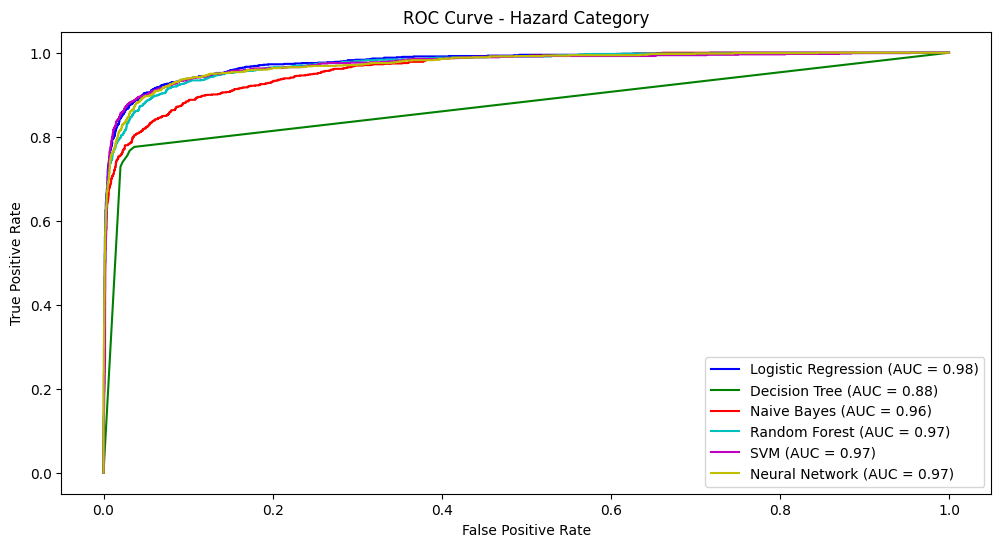

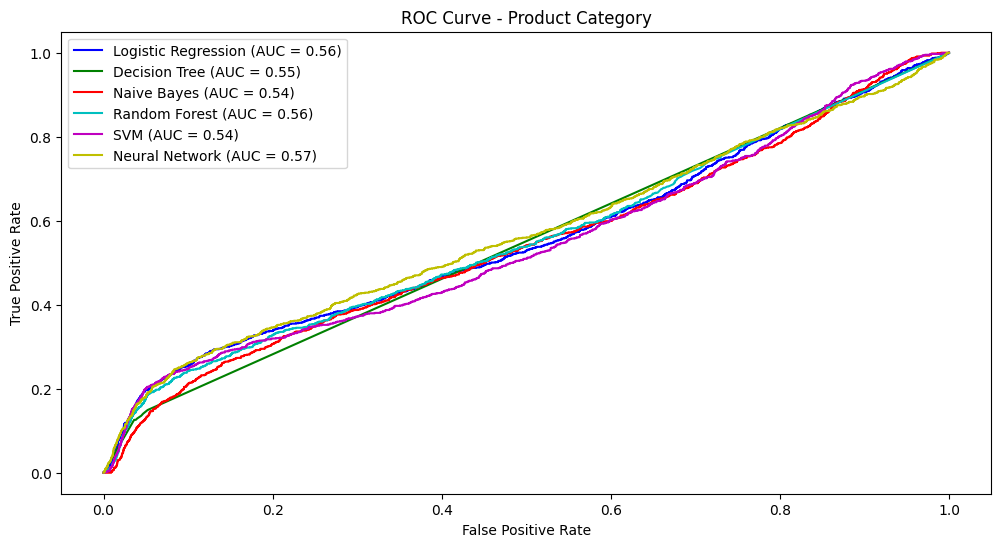

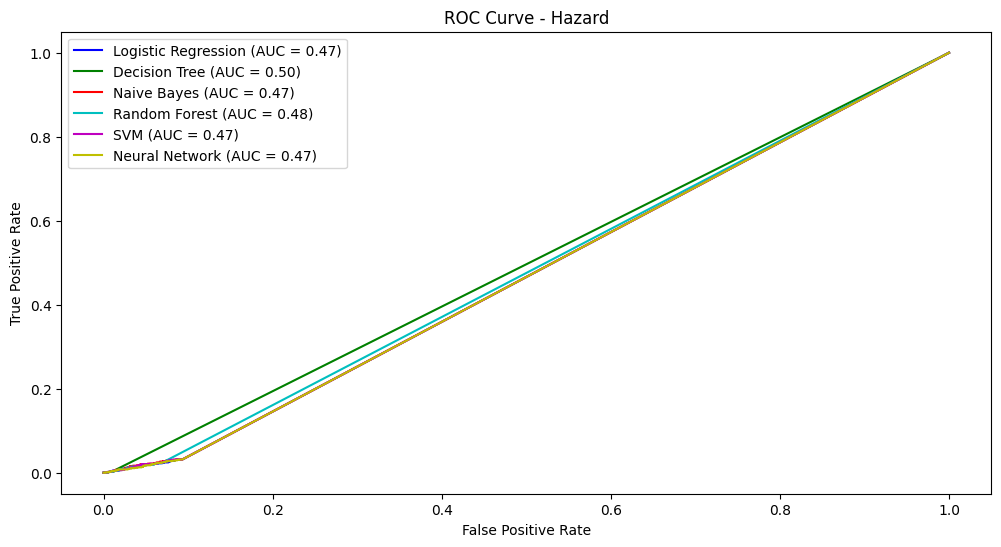

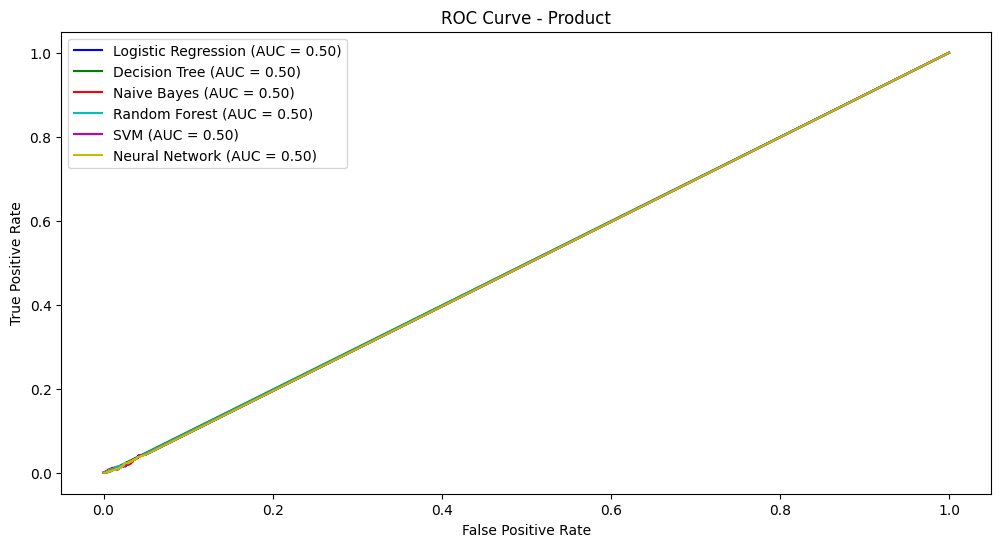

In [63]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier

# Initialize label binarizers
label_binarizer_hazard = LabelBinarizer()
label_binarizer_product = LabelBinarizer()

# Binarize labels
y_test_hazard_cat_bin = label_binarizer_hazard.fit_transform(y_test['hazard-category'])
y_test_hazard_bin = label_binarizer_hazard.fit_transform(y_test['hazard'])
y_test_product_cat_bin = label_binarizer_product.fit_transform(y_test['product-category'])
y_test_product_bin = label_binarizer_product.fit_transform(y_test['product'])

# Colors for plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot for Hazard-Category
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_hazard_proba = multi_target_model.estimators_[0].predict_proba(X_test_tfidf)
    
    # Align predictions
    y_pred_hazard_proba_aligned = np.zeros((len(y_test), y_test_hazard_cat_bin.shape[1]))
    for i in range(y_pred_hazard_proba.shape[1]):
        if i < y_pred_hazard_proba_aligned.shape[1]:
            y_pred_hazard_proba_aligned[:, i] = y_pred_hazard_proba[:, i]

    # Compute ROC
    fpr_hazard, tpr_hazard, _ = roc_curve(y_test_hazard_cat_bin.ravel(), y_pred_hazard_proba_aligned.ravel())
    roc_auc_hazard = auc(fpr_hazard, tpr_hazard)

    # Plot ROC
    plt.plot(fpr_hazard, tpr_hazard, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_hazard:.2f})")

plt.title("ROC Curve - Hazard Category")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Product-Category
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_product_proba = multi_target_model.estimators_[1].predict_proba(X_test_tfidf)
    
    # Align predictions
    y_pred_product_proba_aligned = np.zeros((len(y_test), y_test_product_cat_bin.shape[1]))
    for i in range(y_pred_product_proba.shape[1]):
        if i < y_pred_product_proba_aligned.shape[1]:
            y_pred_product_proba_aligned[:, i] = y_pred_product_proba[:, i]

    # Compute ROC
    fpr_product, tpr_product, _ = roc_curve(y_test_product_cat_bin.ravel(), y_pred_product_proba_aligned.ravel())
    roc_auc_product = auc(fpr_product, tpr_product)

    # Plot ROC
    plt.plot(fpr_product, tpr_product, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_product:.2f})")

plt.title("ROC Curve - Product Category")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Hazard
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_hazard_proba = multi_target_model.estimators_[0].predict_proba(X_test_tfidf)
    
    # Align predictions
    y_pred_hazard_proba_aligned = np.zeros((len(y_test), y_test_hazard_bin.shape[1]))
    for i in range(y_pred_hazard_proba.shape[1]):
        if i < y_pred_hazard_proba_aligned.shape[1]:
            y_pred_hazard_proba_aligned[:, i] = y_pred_hazard_proba[:, i]

    # Compute ROC
    fpr_hazard, tpr_hazard, _ = roc_curve(y_test_hazard_bin.ravel(), y_pred_hazard_proba_aligned.ravel())
    roc_auc_hazard = auc(fpr_hazard, tpr_hazard)

    # Plot ROC
    plt.plot(fpr_hazard, tpr_hazard, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_hazard:.2f})")

plt.title("ROC Curve - Hazard")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Product
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_product_proba = multi_target_model.estimators_[1].predict_proba(X_test_tfidf)
    
    # Align predictions
    y_pred_product_proba_aligned = np.zeros((len(y_test), y_test_product_bin.shape[1]))
    for i in range(y_pred_product_proba.shape[1]):
        if i < y_pred_product_proba_aligned.shape[1]:
            y_pred_product_proba_aligned[:, i] = y_pred_product_proba[:, i]

    # Compute ROC
    fpr_product, tpr_product, _ = roc_curve(y_test_product_bin.ravel(), y_pred_product_proba_aligned.ravel())
    roc_auc_product = auc(fpr_product, tpr_product)

    # Plot ROC
    plt.plot(fpr_product, tpr_product, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_product:.2f})")

plt.title("ROC Curve - Product")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


###  `plot_metrics` Function

The `plot_metrics` function is designed to visually represent the performance of various machine learning algorithms across different evaluation metrics and target categories. Here's a breakdown of its purpose:

1. **Data Transformation**:
   - Converts the `classification_pivot` DataFrame into a long format suitable for plotting, splitting metrics by algorithm, target category, and metric value.
   - Processes `accuracy_pivot` data similarly, combining accuracy metrics with other classification metrics for unified visualization.

2. **Combination of Metrics**:
   - Merges accuracy metrics with other evaluation metrics (e.g., precision, recall, F1-score) into a single dataset for easier comparison.

3. **Visualization**:
   - Uses **seaborn's barplot** to create side-by-side bar charts for each target category, comparing algorithm performance across metrics.
   - Displays these plots on multiple subplots, with one subplot per target category.

4. **Customization**:
   - Titles, labels, legends, and axis limits are set to enhance clarity and interpretability.

5. **Output**:
   - Produces a figure with a clear comparison of algorithm performance across multiple evaluation metrics for different categories, facilitating insights into model effectiveness.

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(classification_pivot, accuracy_pivot, categories):
    # Convert classification_pivot to a long format for plotting
    classification_long = classification_pivot.melt(ignore_index=False).reset_index()
    classification_long.columns = ['Algorithm', 'Metric', 'Target', 'Value']

    # Prepare accuracy data for each target category
    accuracy_long = accuracy_pivot.reset_index().melt(id_vars='Algorithm', var_name='Target', value_name='Value')
    accuracy_long['Metric'] = 'Accuracy'

    # Combine classification metrics with accuracy metrics
    combined_metrics = pd.concat([classification_long, accuracy_long])

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(24, 10))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        # Filter data for the current category
        data = combined_metrics[combined_metrics['Target'] == category]

        # Plotting
        sns.barplot(
            data=data, 
            x="Algorithm", 
            y="Value", 
            hue="Metric", 
            ax=axes[i], 
            palette="Set2"
        )

        axes[i].set_title(f"Performance Metrics for {category}", fontsize=16)
        axes[i].set_xlabel("Algorithm", fontsize=14)
        axes[i].set_ylabel("Metric Value", fontsize=14)
        axes[i].legend(title="Metric", fontsize=12)
        axes[i].set_ylim(0, 1)

    # Layout and show
    plt.tight_layout()
    plt.show()

## Title Analysis

### Comparison of Basic ML Algorithms

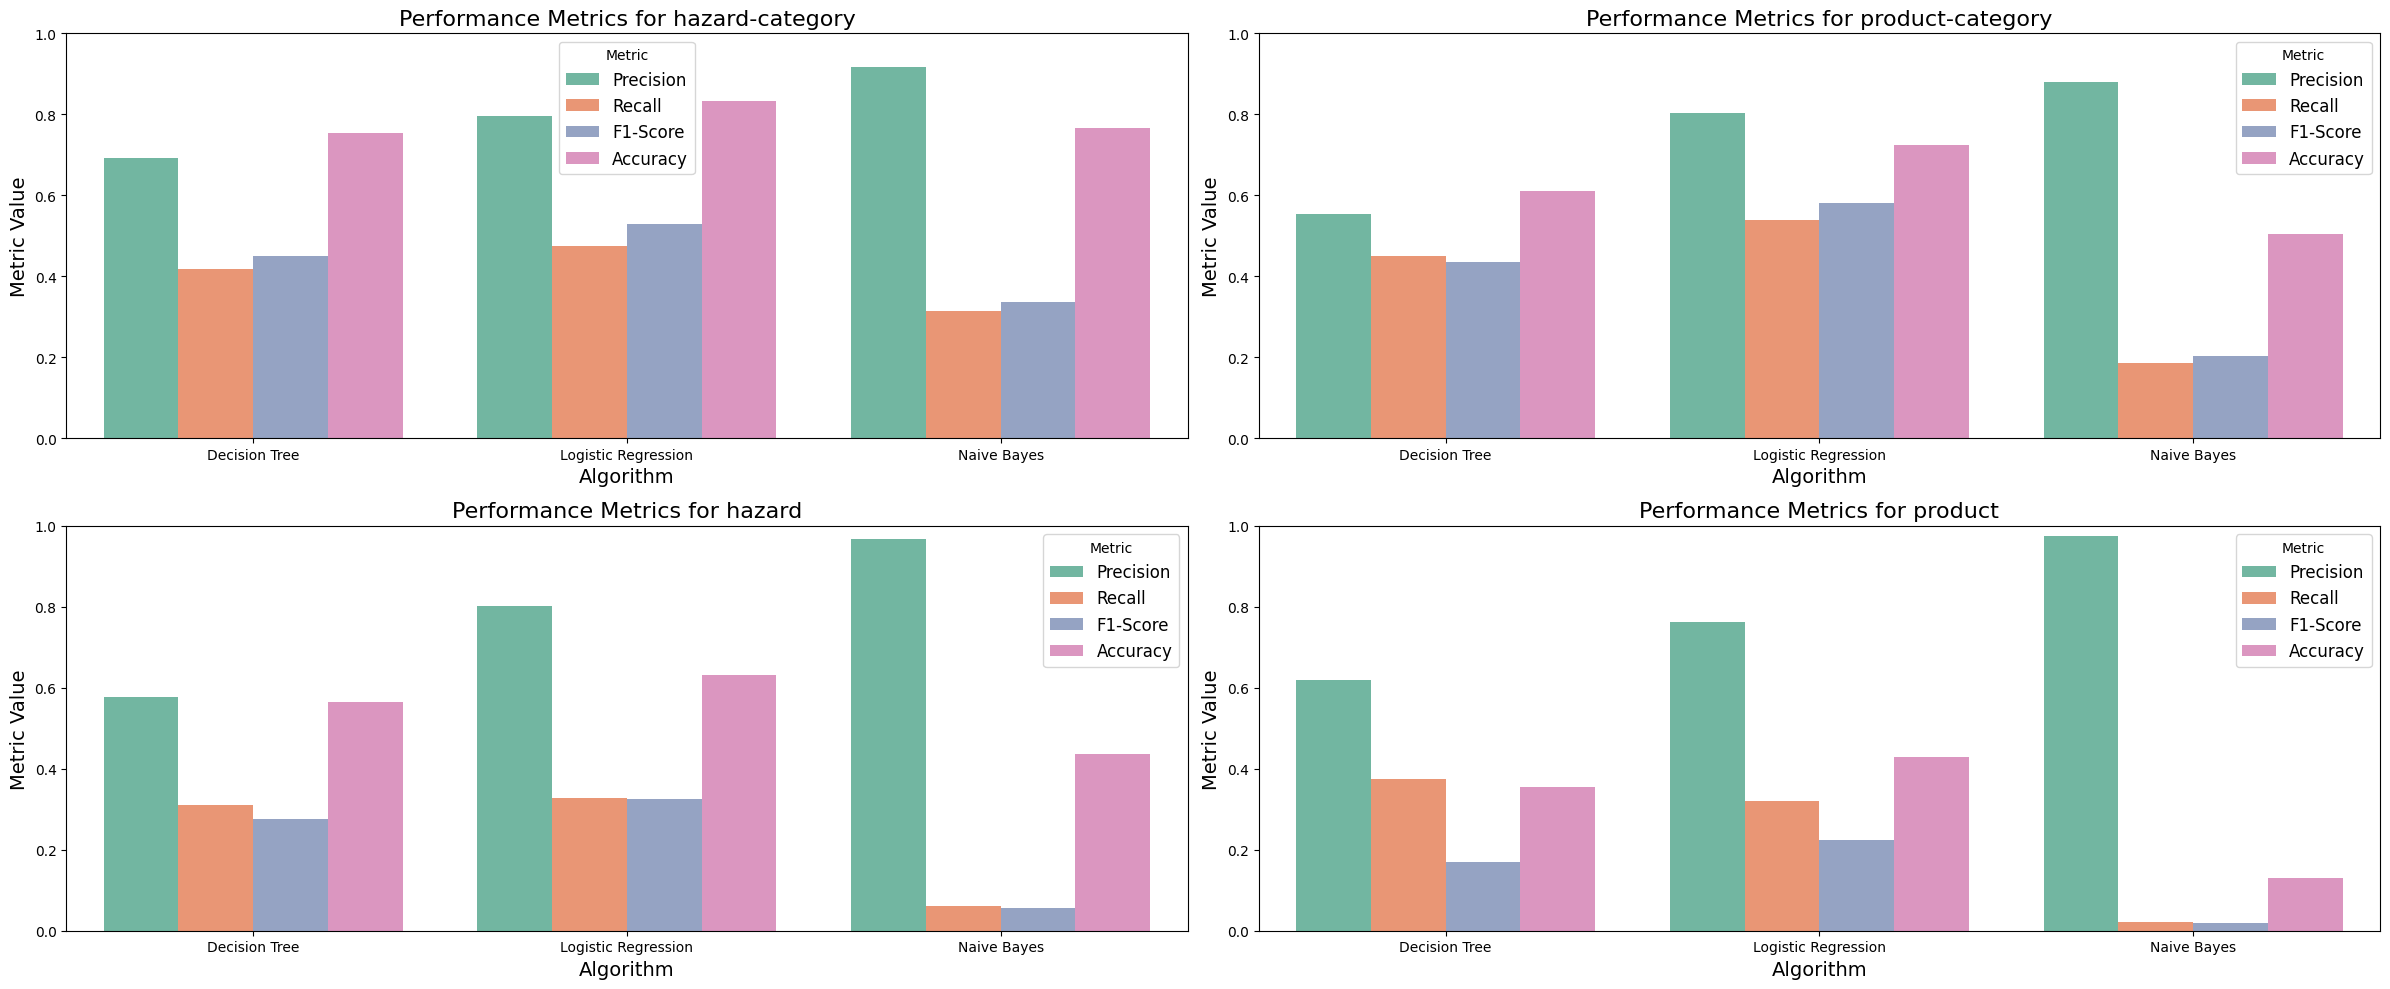

In [72]:
# Example usage
categories = ["hazard-category", "product-category", "hazard", "product"]

# Call the function with your data
plot_metrics(classification_pivot, accuracy_pivot, categories)

### Comparison of Advanced ML Algorithms

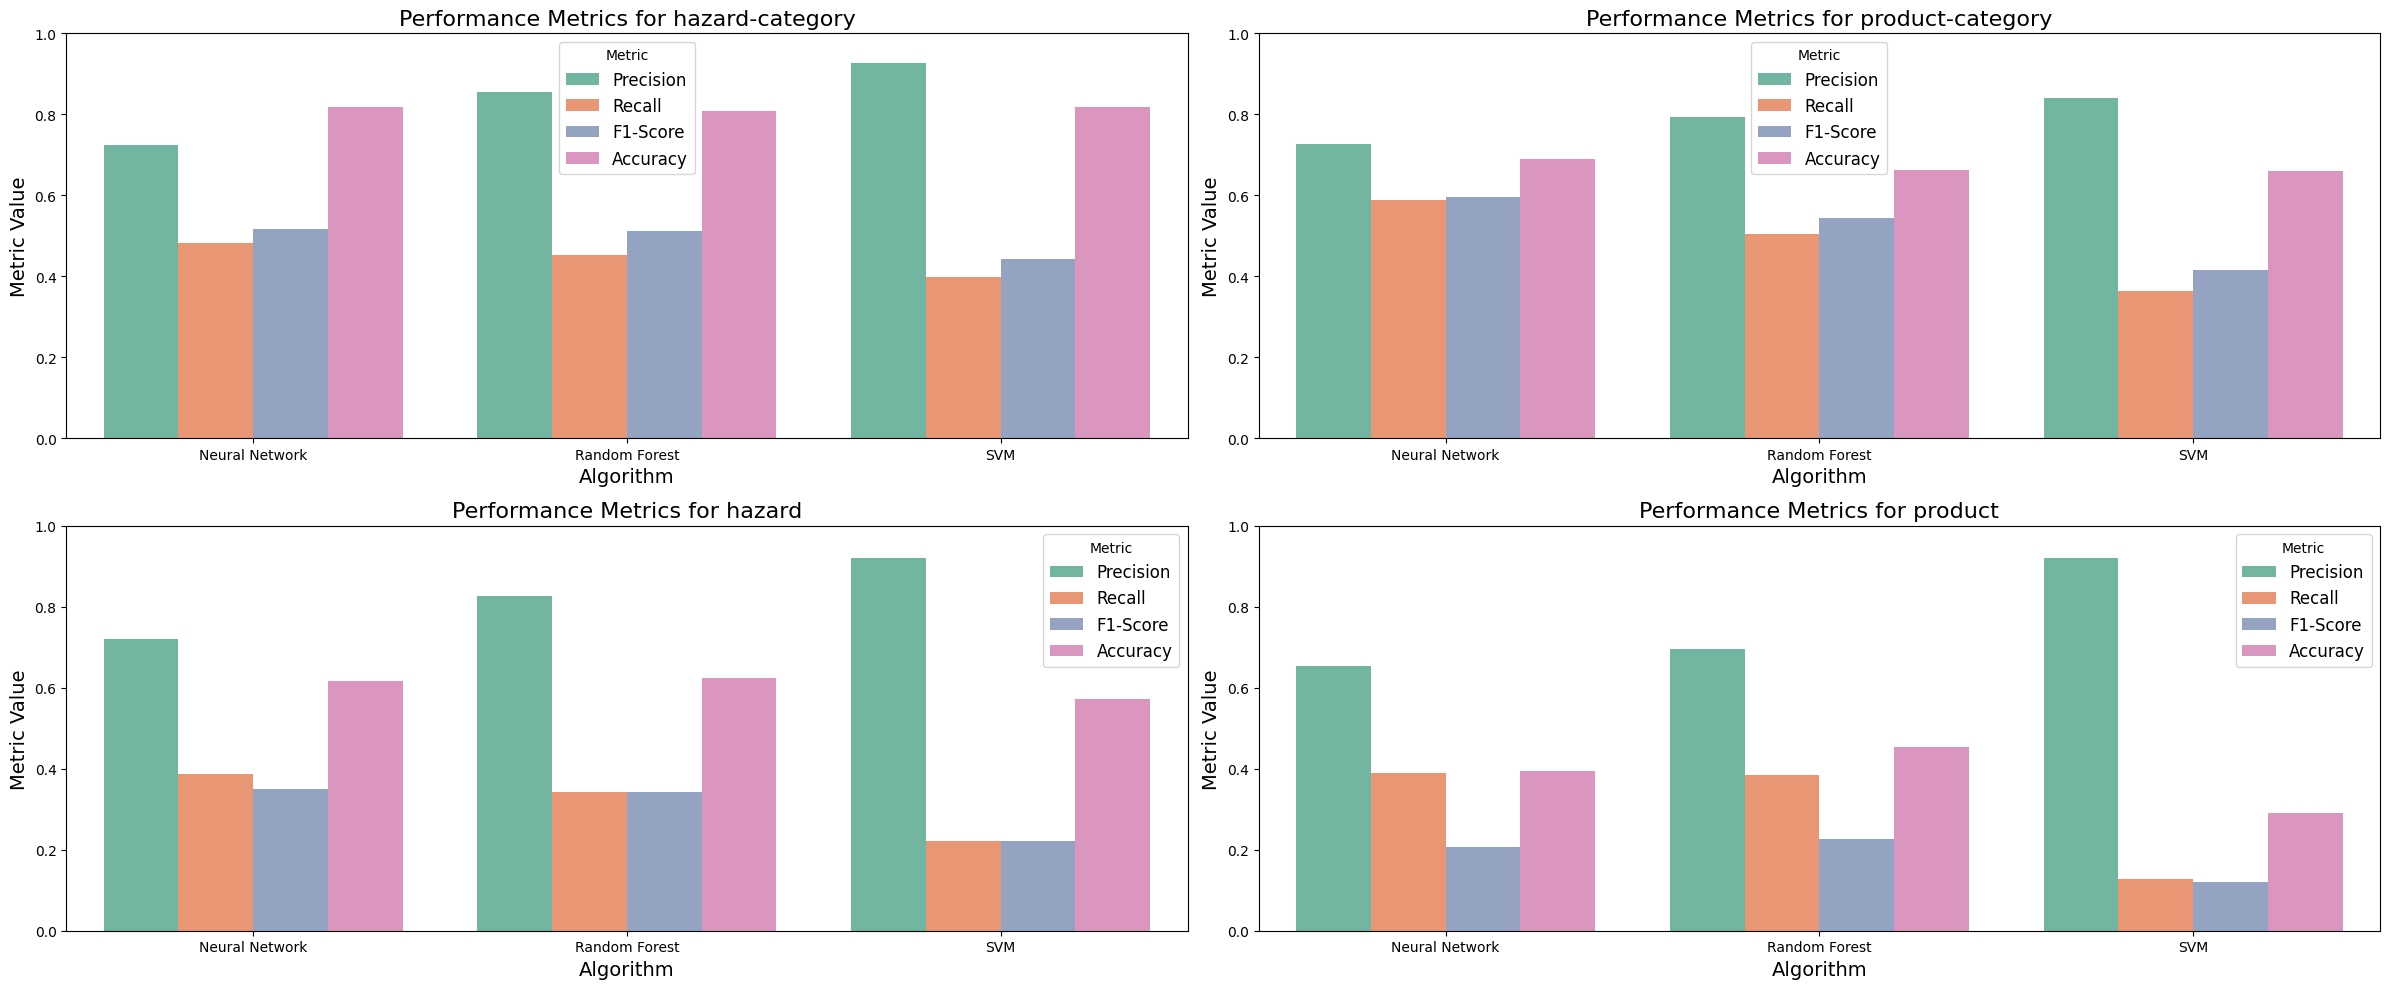

In [73]:
# Example usage
categories = ["hazard-category", "product-category", "hazard", "product"]

# Call the function with your data
plot_metrics(classification_pivot2, accuracy_pivot2, categories)

### Comparison of both Basic-Advanced ML Algorithms

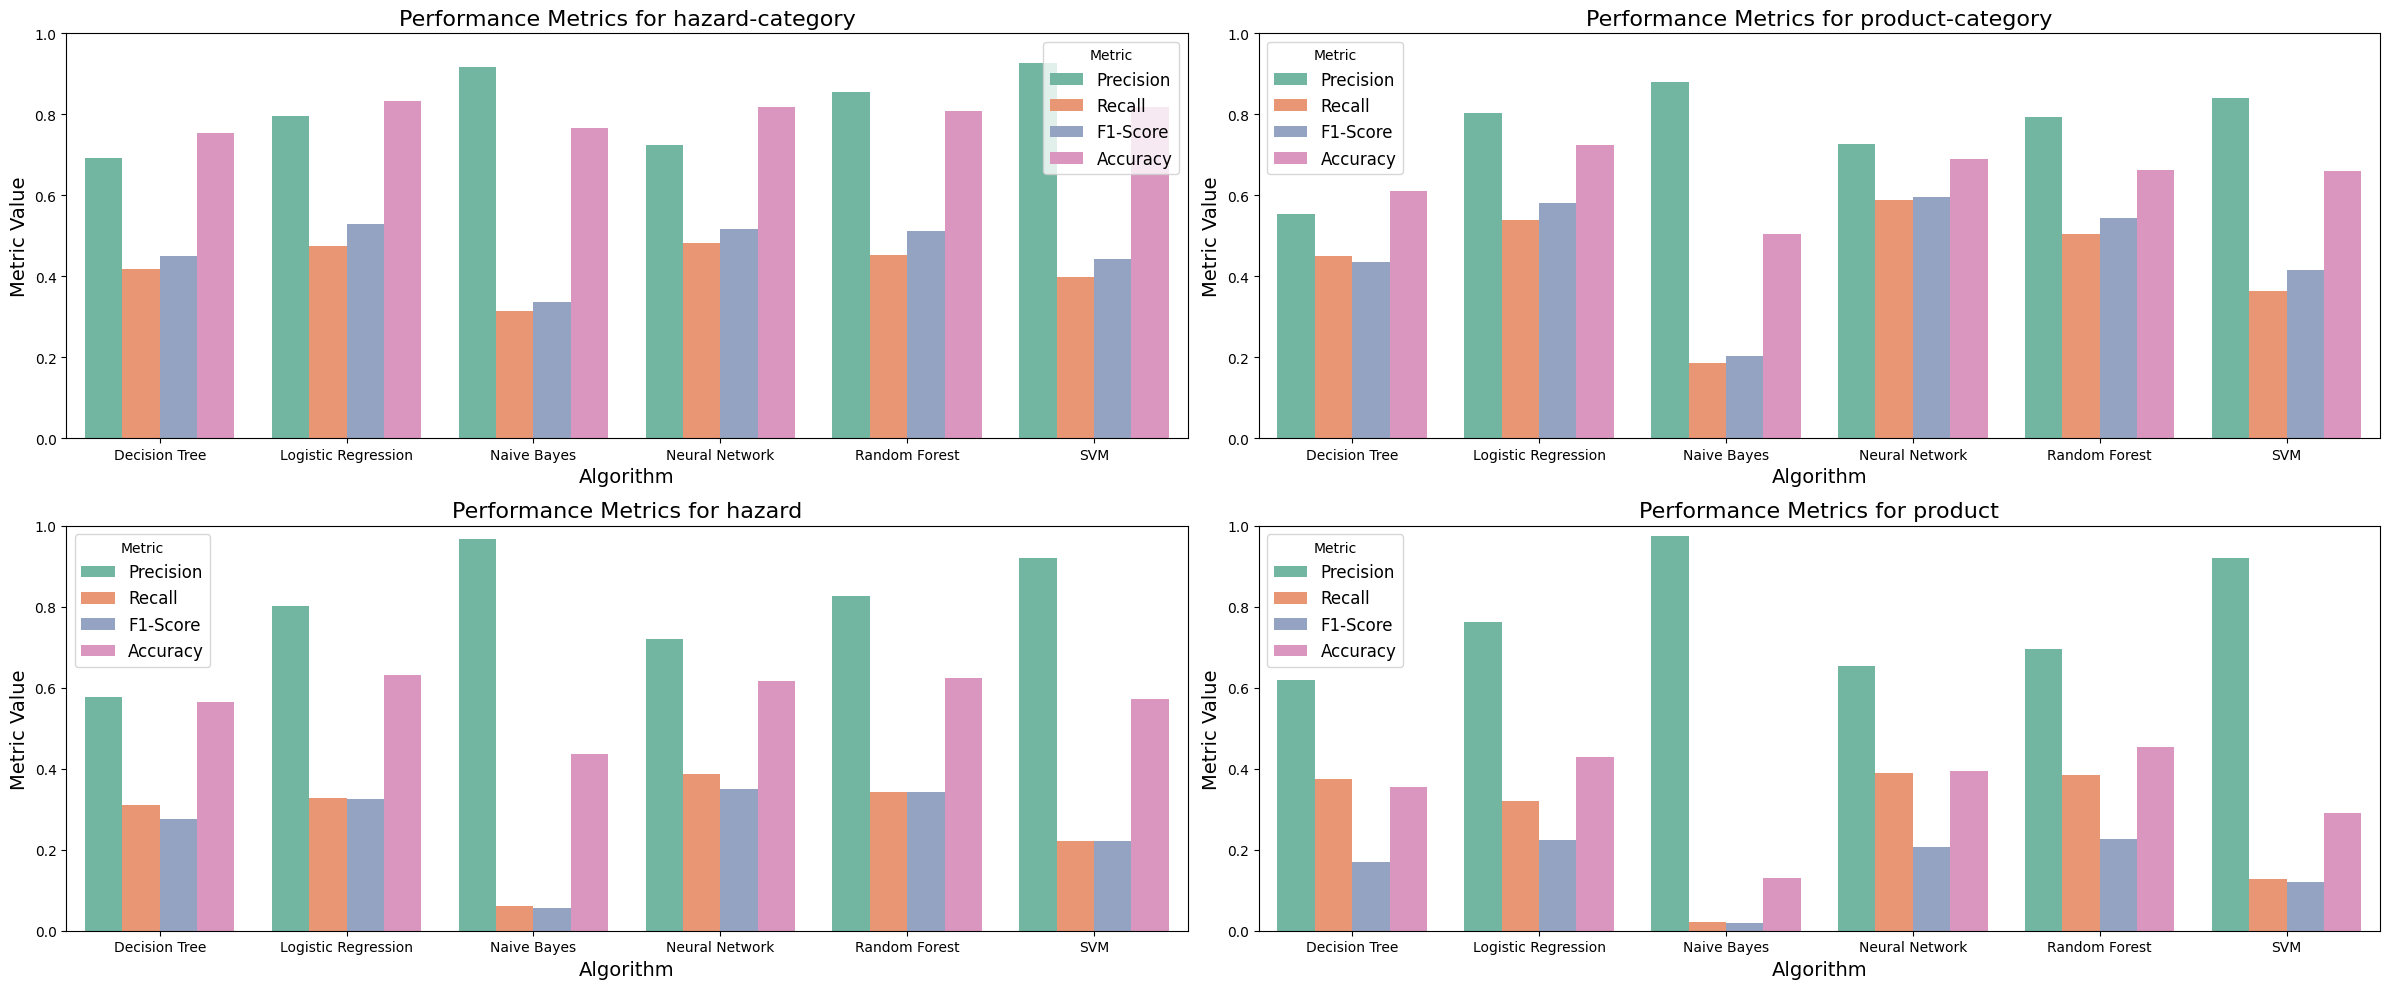

In [74]:
# Example usage
categories = ["hazard-category", "product-category", "hazard", "product"]

# Call the function with your data
plot_metrics(classification_pivot_comparison, accuracy_pivot_comparison, categories)

## Text Analysis

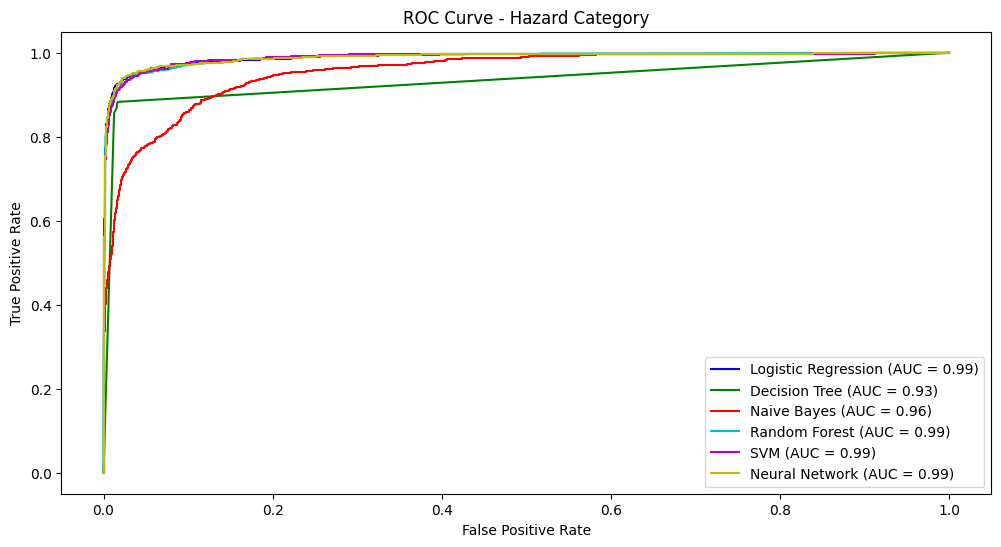

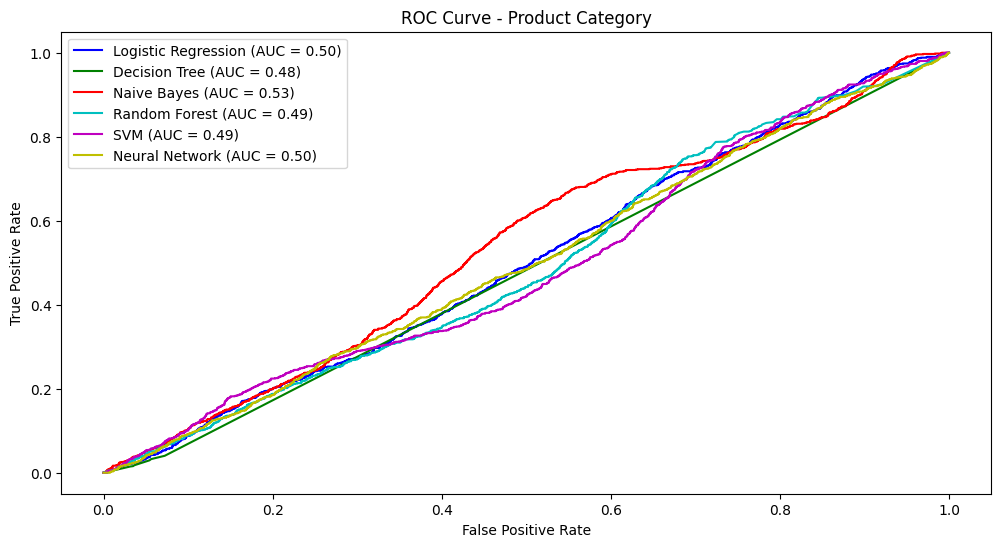

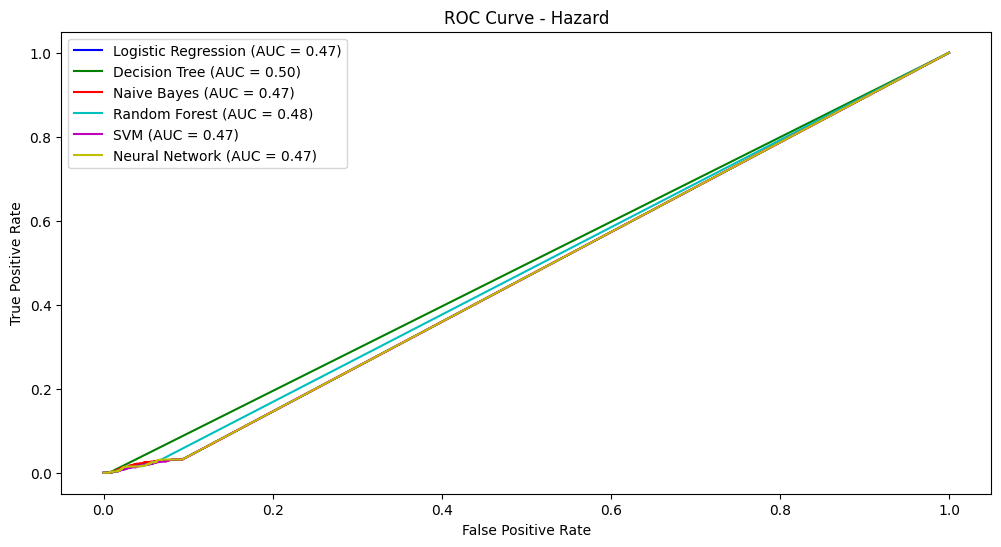

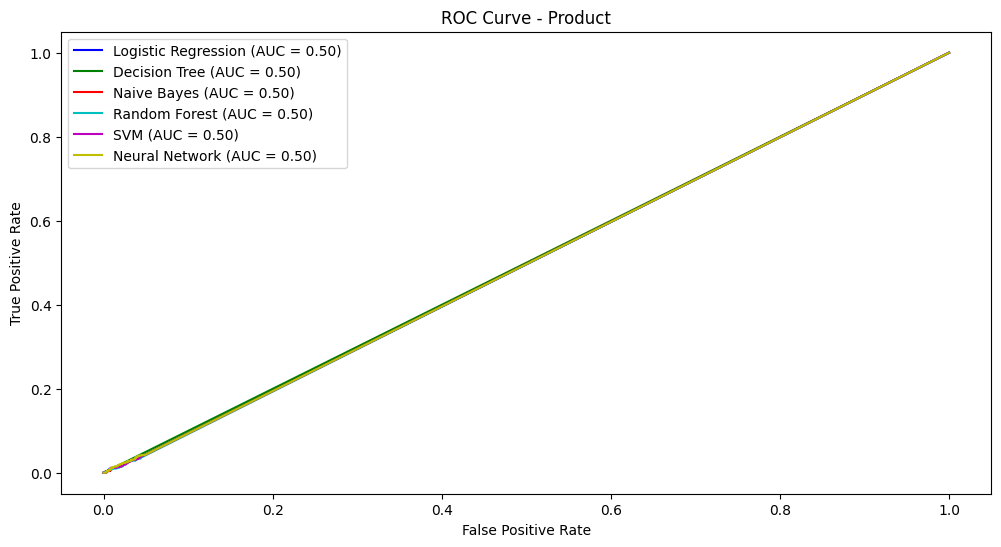

In [75]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier

# Initialize label binarizers
label_binarizer_hazard = LabelBinarizer()
label_binarizer_product = LabelBinarizer()

# Binarize labels
y_test_hazard_cat_bin = label_binarizer_hazard.fit_transform(y_test_t['hazard-category'])
y_test_product_cat_bin = label_binarizer_product.fit_transform(y_test_t['product-category'])
y_test_hazard_bin = label_binarizer_hazard.fit_transform(y_test_t['hazard'])
y_test_product_bin = label_binarizer_product.fit_transform(y_test_t['product'])

# Colors for plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot for Hazard_Category
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf_t, y_train_t)

    # Predict probabilities
    y_pred_hazard_proba = multi_target_model.estimators_[0].predict_proba(X_test_tfidf_t)
    
    # Align predictions
    y_pred_hazard_proba_aligned = np.zeros((len(y_test_t), y_test_hazard_cat_bin.shape[1]))
    for i in range(y_pred_hazard_proba.shape[1]):
        if i < y_pred_hazard_proba_aligned.shape[1]:
            y_pred_hazard_proba_aligned[:, i] = y_pred_hazard_proba[:, i]

    # Compute ROC
    fpr_hazard, tpr_hazard, _ = roc_curve(y_test_hazard_cat_bin.ravel(), y_pred_hazard_proba_aligned.ravel())
    roc_auc_hazard = auc(fpr_hazard, tpr_hazard)

    # Plot ROC
    plt.plot(fpr_hazard, tpr_hazard, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_hazard:.2f})")

plt.title("ROC Curve - Hazard Category")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Product-Category
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_product_proba = multi_target_model.estimators_[1].predict_proba(X_test_tfidf_t)
    
    # Align predictions
    y_pred_product_proba_aligned = np.zeros((len(y_test_t), y_test_product_cat_bin.shape[1]))
    for i in range(y_pred_product_proba.shape[1]):
        if i < y_pred_product_proba_aligned.shape[1]:
            y_pred_product_proba_aligned[:, i] = y_pred_product_proba[:, i]

    # Compute ROC
    fpr_product, tpr_product, _ = roc_curve(y_test_product_cat_bin.ravel(), y_pred_product_proba_aligned.ravel())
    roc_auc_product = auc(fpr_product, tpr_product)

    # Plot ROC
    plt.plot(fpr_product, tpr_product, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_product:.2f})")

plt.title("ROC Curve - Product Category")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Hazard
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf_t, y_train_t)

    # Predict probabilities
    y_pred_hazard_proba = multi_target_model.estimators_[0].predict_proba(X_test_tfidf_t)
    
    # Align predictions
    y_pred_hazard_proba_aligned = np.zeros((len(y_test_t), y_test_hazard_bin.shape[1]))
    for i in range(y_pred_hazard_proba.shape[1]):
        if i < y_pred_hazard_proba_aligned.shape[1]:
            y_pred_hazard_proba_aligned[:, i] = y_pred_hazard_proba[:, i]

    # Compute ROC
    fpr_hazard, tpr_hazard, _ = roc_curve(y_test_hazard_bin.ravel(), y_pred_hazard_proba_aligned.ravel())
    roc_auc_hazard = auc(fpr_hazard, tpr_hazard)

    # Plot ROC
    plt.plot(fpr_hazard, tpr_hazard, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_hazard:.2f})")

plt.title("ROC Curve - Hazard")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Plot for Product-Category
plt.figure(figsize=(12, 6))
for idx, (algorithm_name, model) in enumerate(algorithms_merged.items()):
    # Wrap the model with MultiOutputClassifier
    multi_target_model = MultiOutputClassifier(model, n_jobs=1)
    multi_target_model.fit(X_train_tfidf, y_train)

    # Predict probabilities
    y_pred_product_proba = multi_target_model.estimators_[1].predict_proba(X_test_tfidf_t)
    
    # Align predictions
    y_pred_product_proba_aligned = np.zeros((len(y_test_t), y_test_product_bin.shape[1]))
    for i in range(y_pred_product_proba.shape[1]):
        if i < y_pred_product_proba_aligned.shape[1]:
            y_pred_product_proba_aligned[:, i] = y_pred_product_proba[:, i]

    # Compute ROC
    fpr_product, tpr_product, _ = roc_curve(y_test_product_bin.ravel(), y_pred_product_proba_aligned.ravel())
    roc_auc_product = auc(fpr_product, tpr_product)

    # Plot ROC
    plt.plot(fpr_product, tpr_product, color=colors[idx % len(colors)], 
             label=f"{algorithm_name} (AUC = {roc_auc_product:.2f})")

plt.title("ROC Curve - Product")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Comparison of Basic ML Algorithms

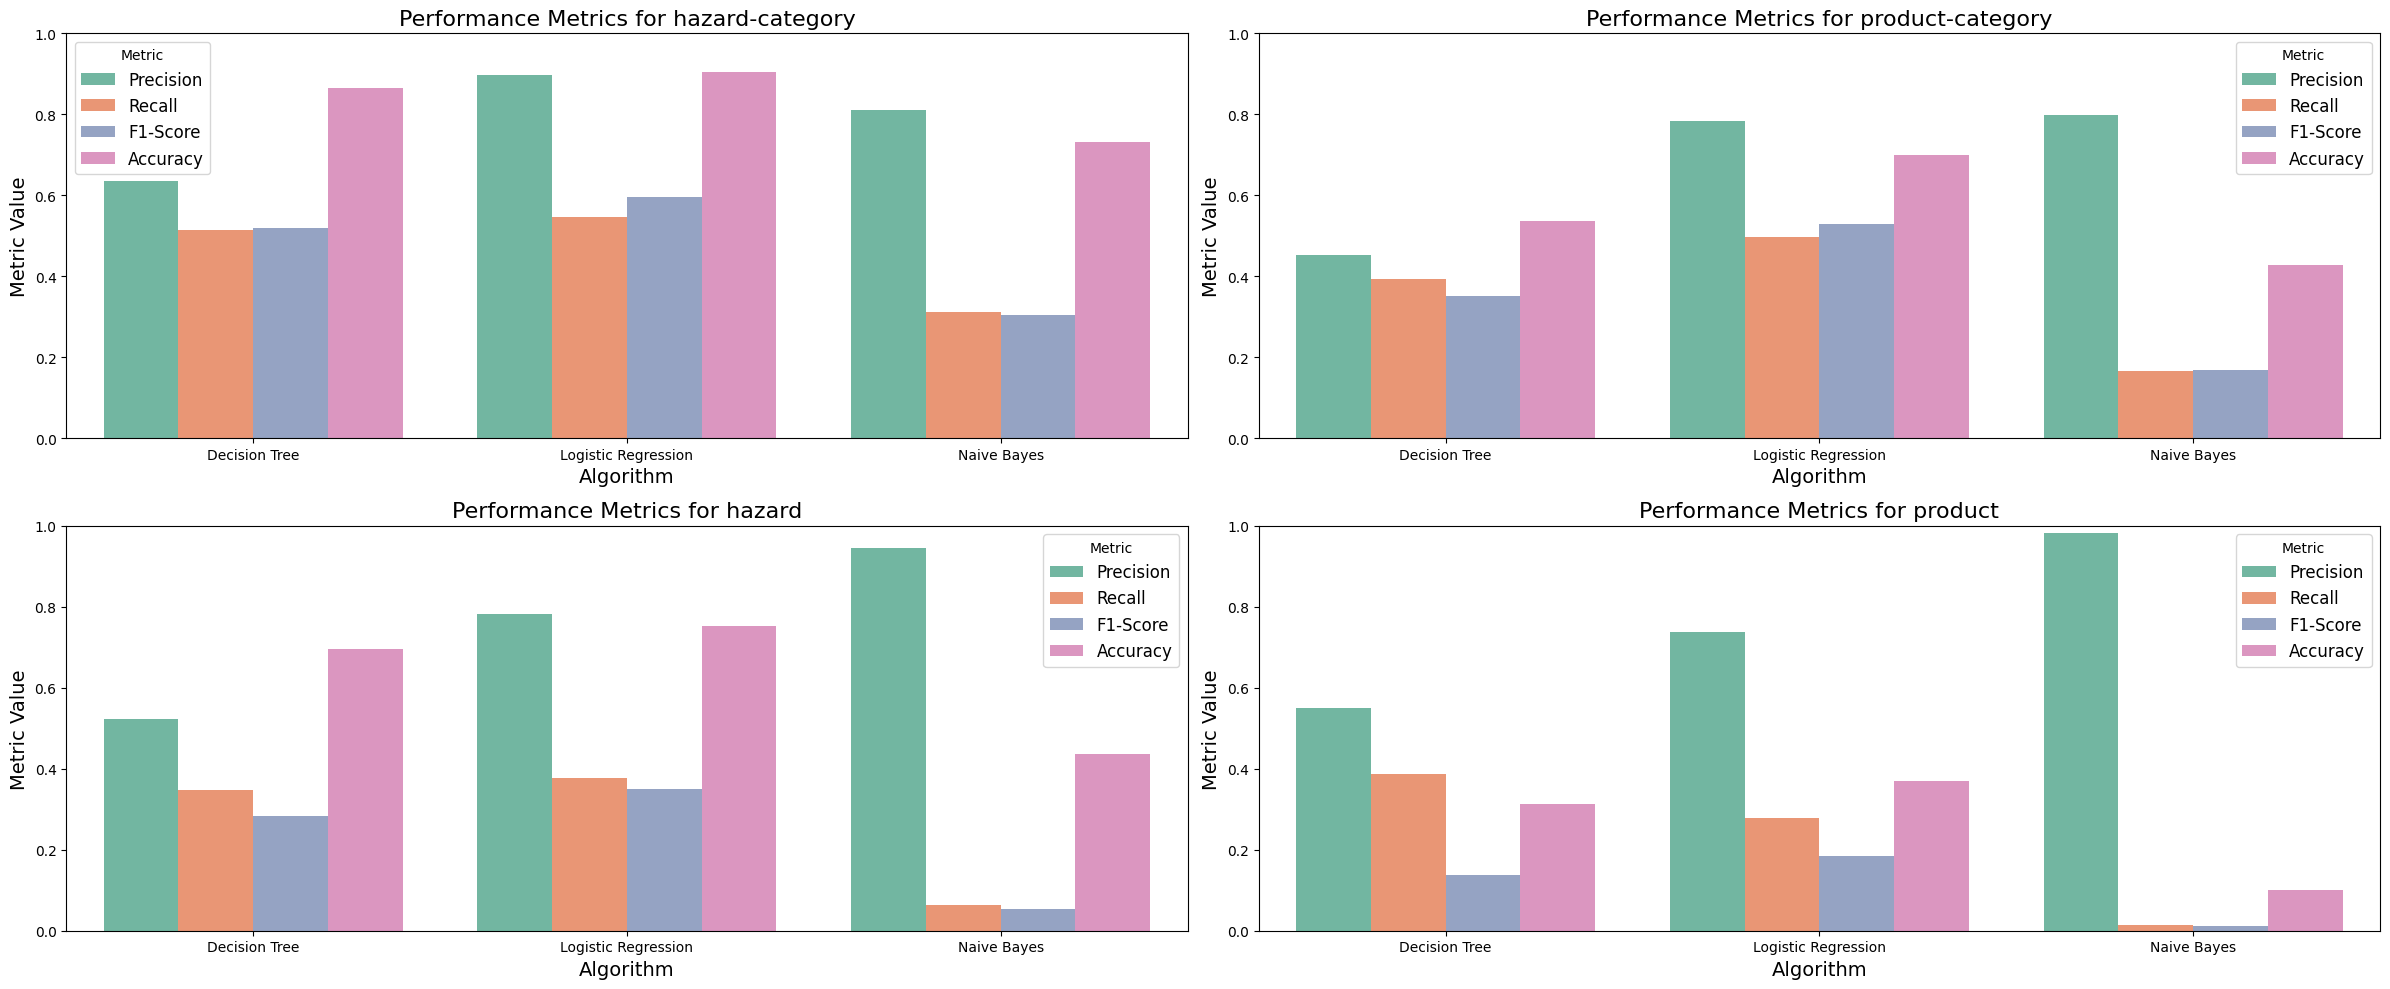

In [76]:
# Example usage
categories = ["hazard-category", "product-category", "hazard", "product"]

# Call the function with your data
plot_metrics(classification_pivot_t, accuracy_pivot_t, categories)

### Comparison of Advanced ML Algorithms 

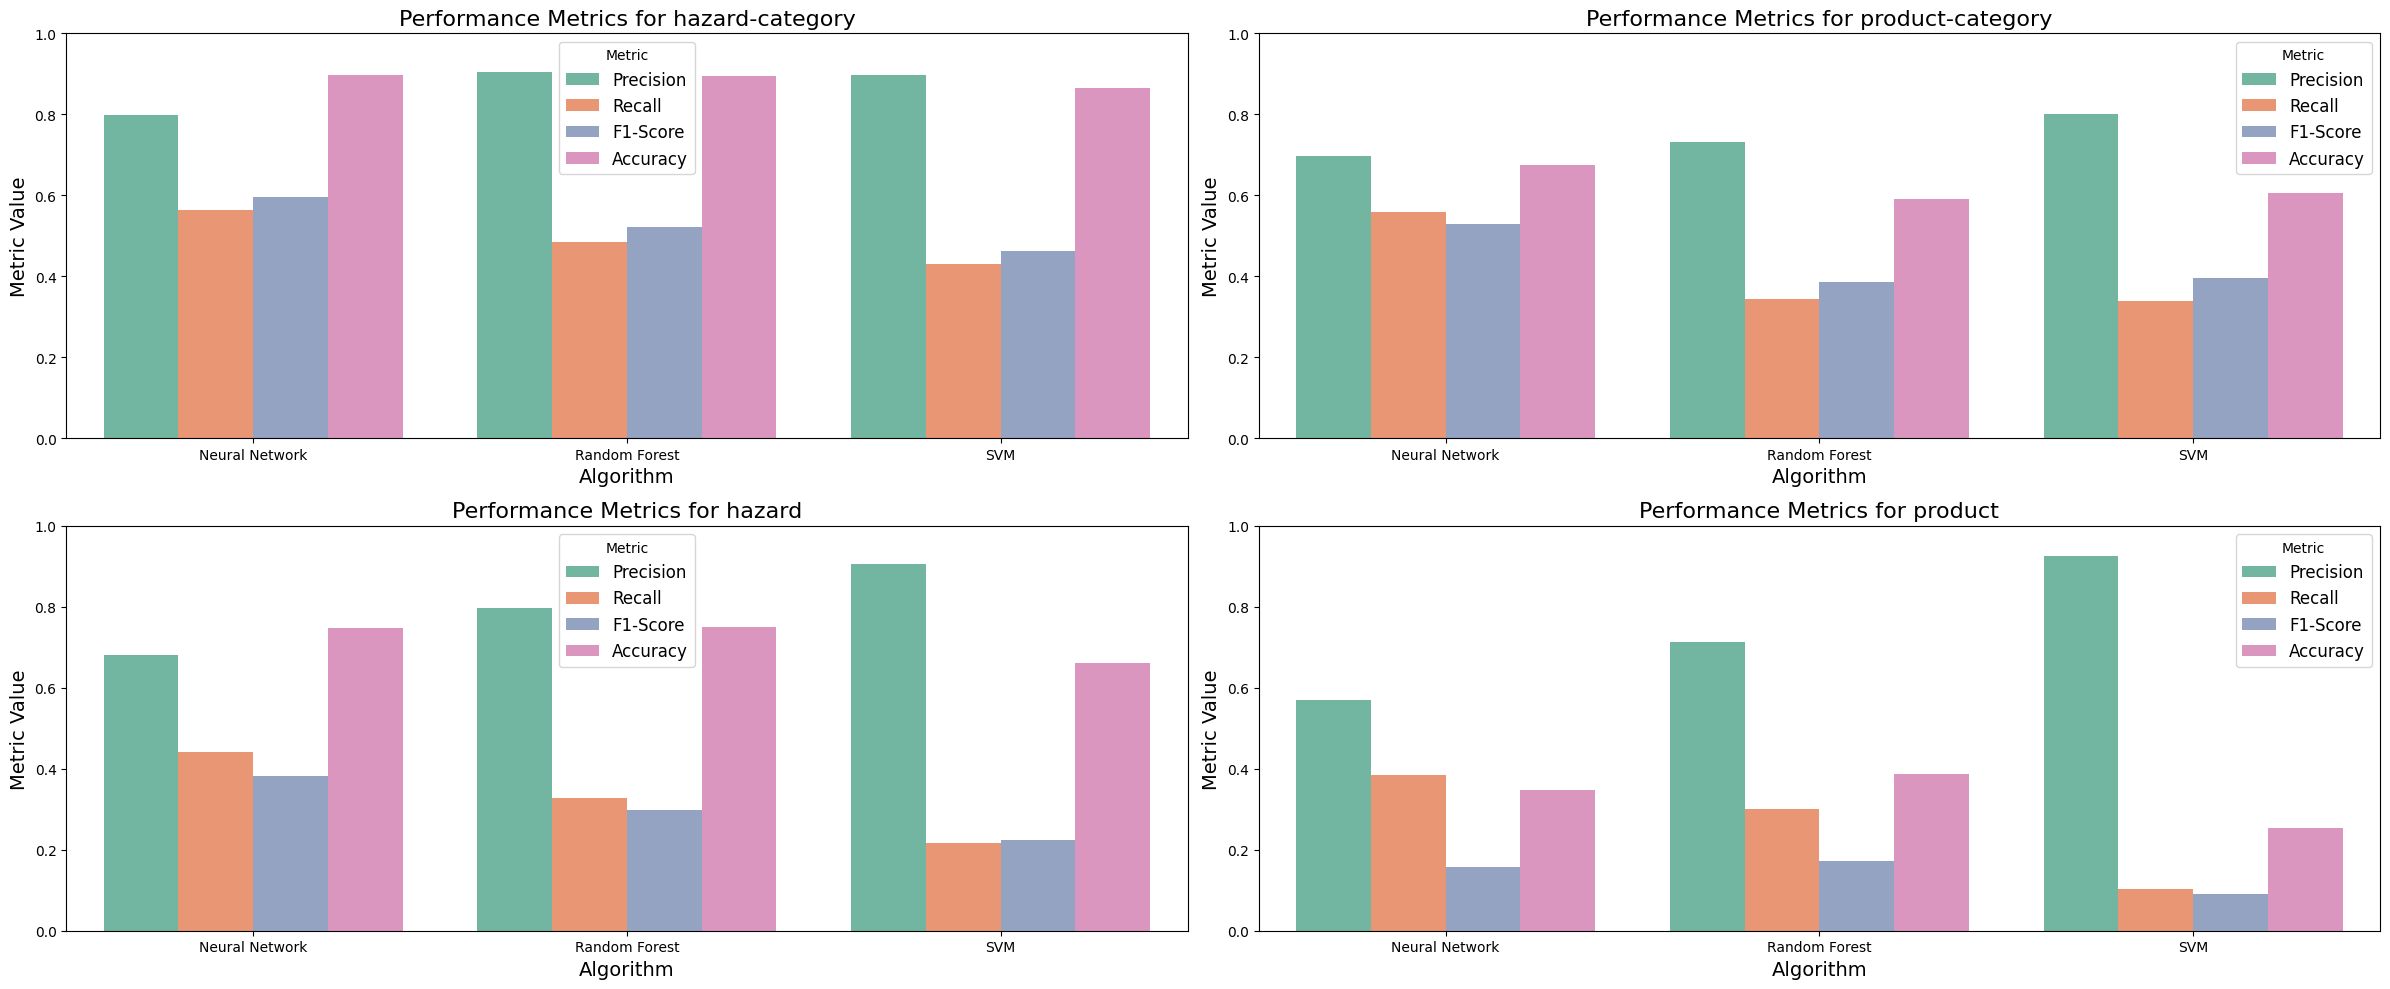

In [77]:
# Example usage
categories = ["hazard-category", "product-category", "hazard", "product"]

# Call the function with your data
plot_metrics(classification_pivot_t_2, accuracy_pivot_t_2, categories)

### Comparison of both Basic-Advanced ML Algorithms 

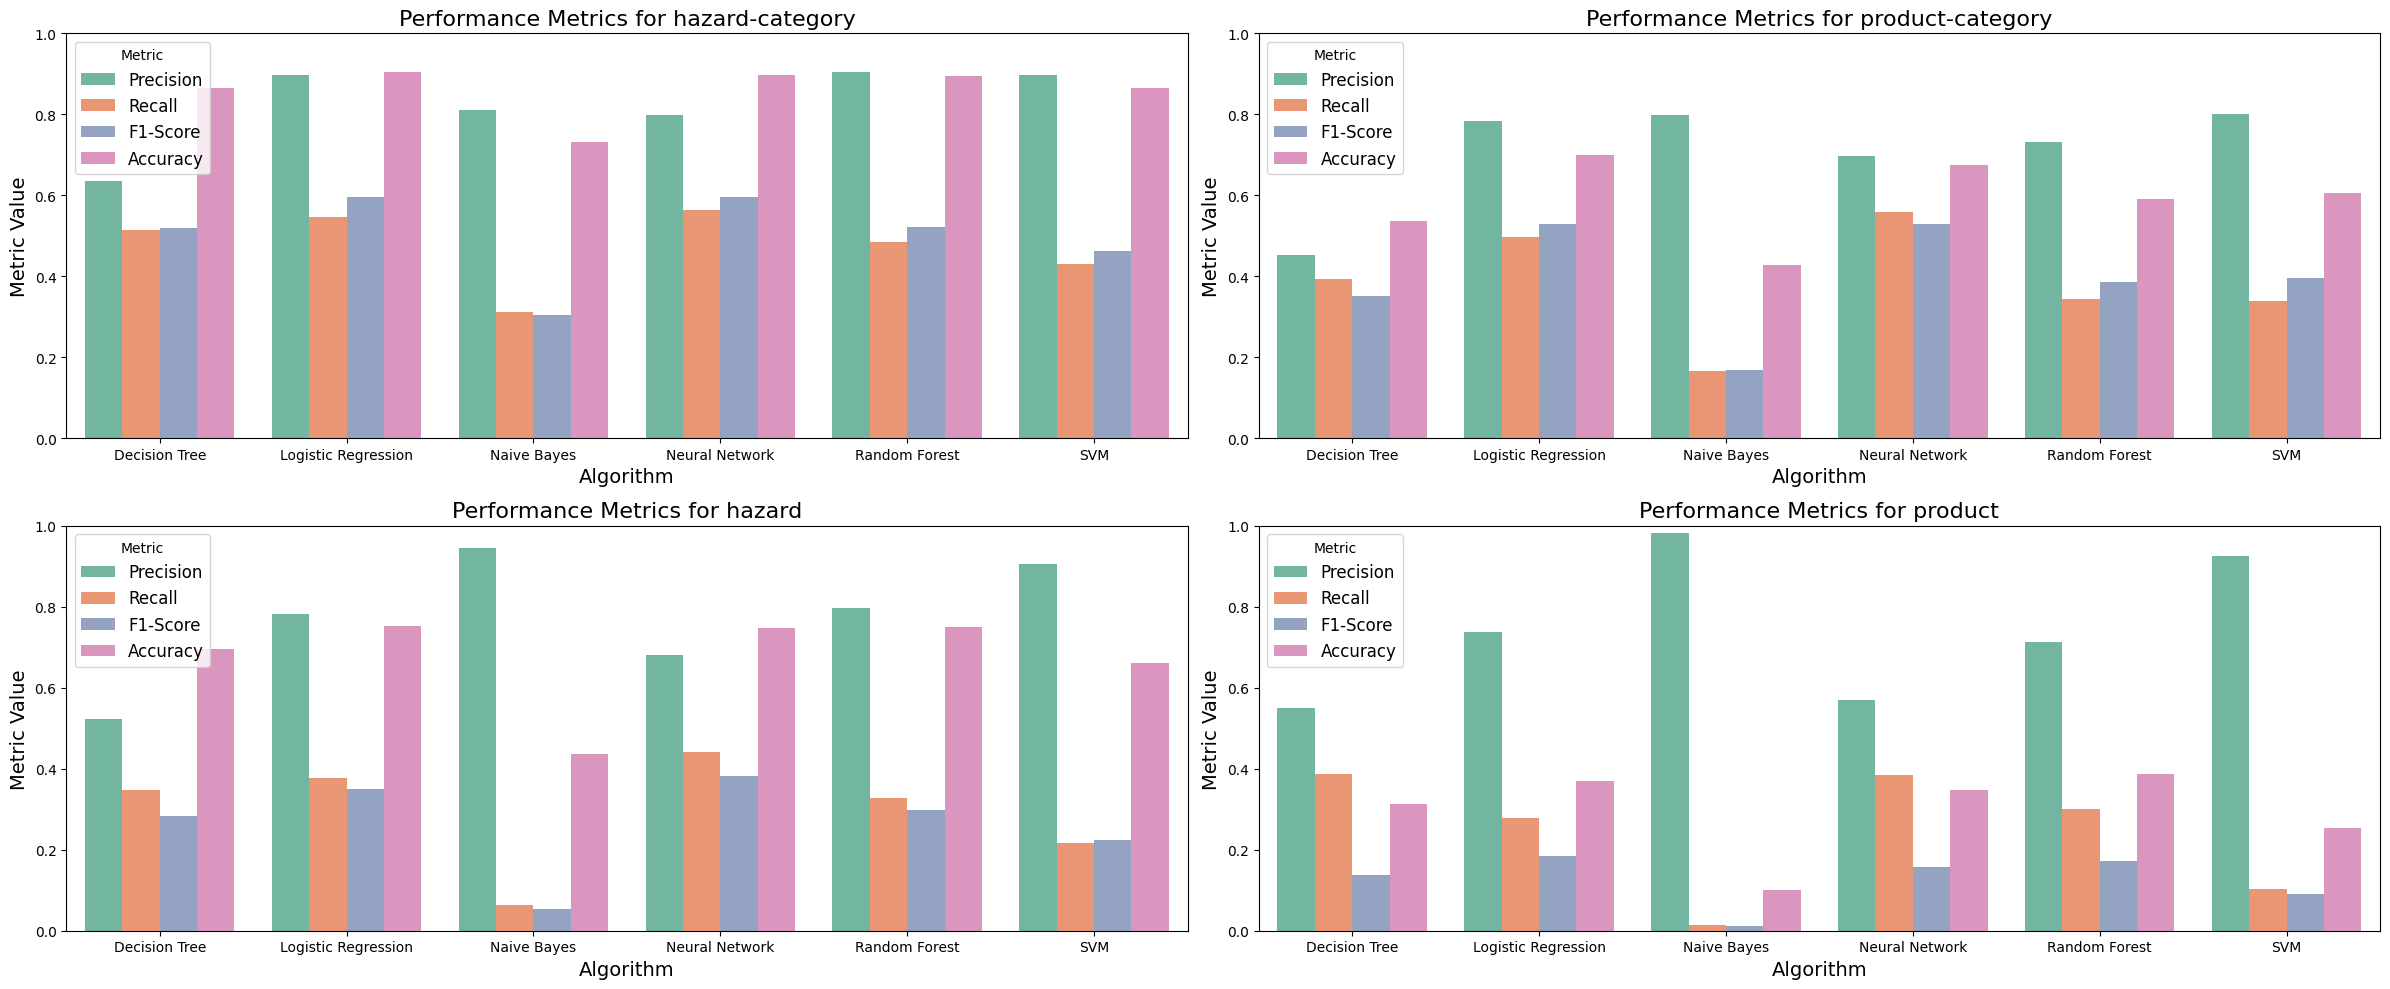

In [78]:
# Example usage
categories = ["hazard-category", "product-category", "hazard", "product"]

# Call the function with your data
plot_metrics(classification_pivot_comparison_t, accuracy_pivot_comparison_t, categories)

## Text-Title Comparison

### Comparison of All ML Algorithms (Basic to Advanced) 

In [79]:
# Add a column to differentiate between text and title analysis
classification_df_t['Analysis'] = 'Text Analysis'
accuracy_df_t['Analysis'] = 'Text Analysis'
classification_df['Analysis'] = 'Title Analysis'
accuracy_df['Analysis'] = 'Title Analysis'
classification_df_t_2['Analysis'] = 'Text Analysis'
accuracy_df_t_2['Analysis'] = 'Text Analysis'
classification_df2['Analysis'] = 'Title Analysis'
accuracy_df2['Analysis'] = 'Title Analysis'


# Combine the classification and accuracy DataFrames for both analyses
combined_classification_df = pd.concat([classification_df_t, classification_df, classification_df2, classification_df_t_2])
combined_accuracy_df = pd.concat([accuracy_df_t, accuracy_df, accuracy_df2, accuracy_df_t_2])

# Pivot the combined DataFrames
combined_classification_pivot = combined_classification_df.pivot_table(index=['Algorithm', 'Analysis'], columns='Target', values=['Precision', 'Recall', 'F1-Score'])
combined_accuracy_pivot = combined_accuracy_df.pivot_table(index=['Algorithm', 'Analysis'], columns='Target', values='Accuracy')

# Flatten the MultiIndex columns for easier handling
combined_classification_pivot.columns = ['_'.join(col).strip() for col in combined_classification_pivot.columns.values]

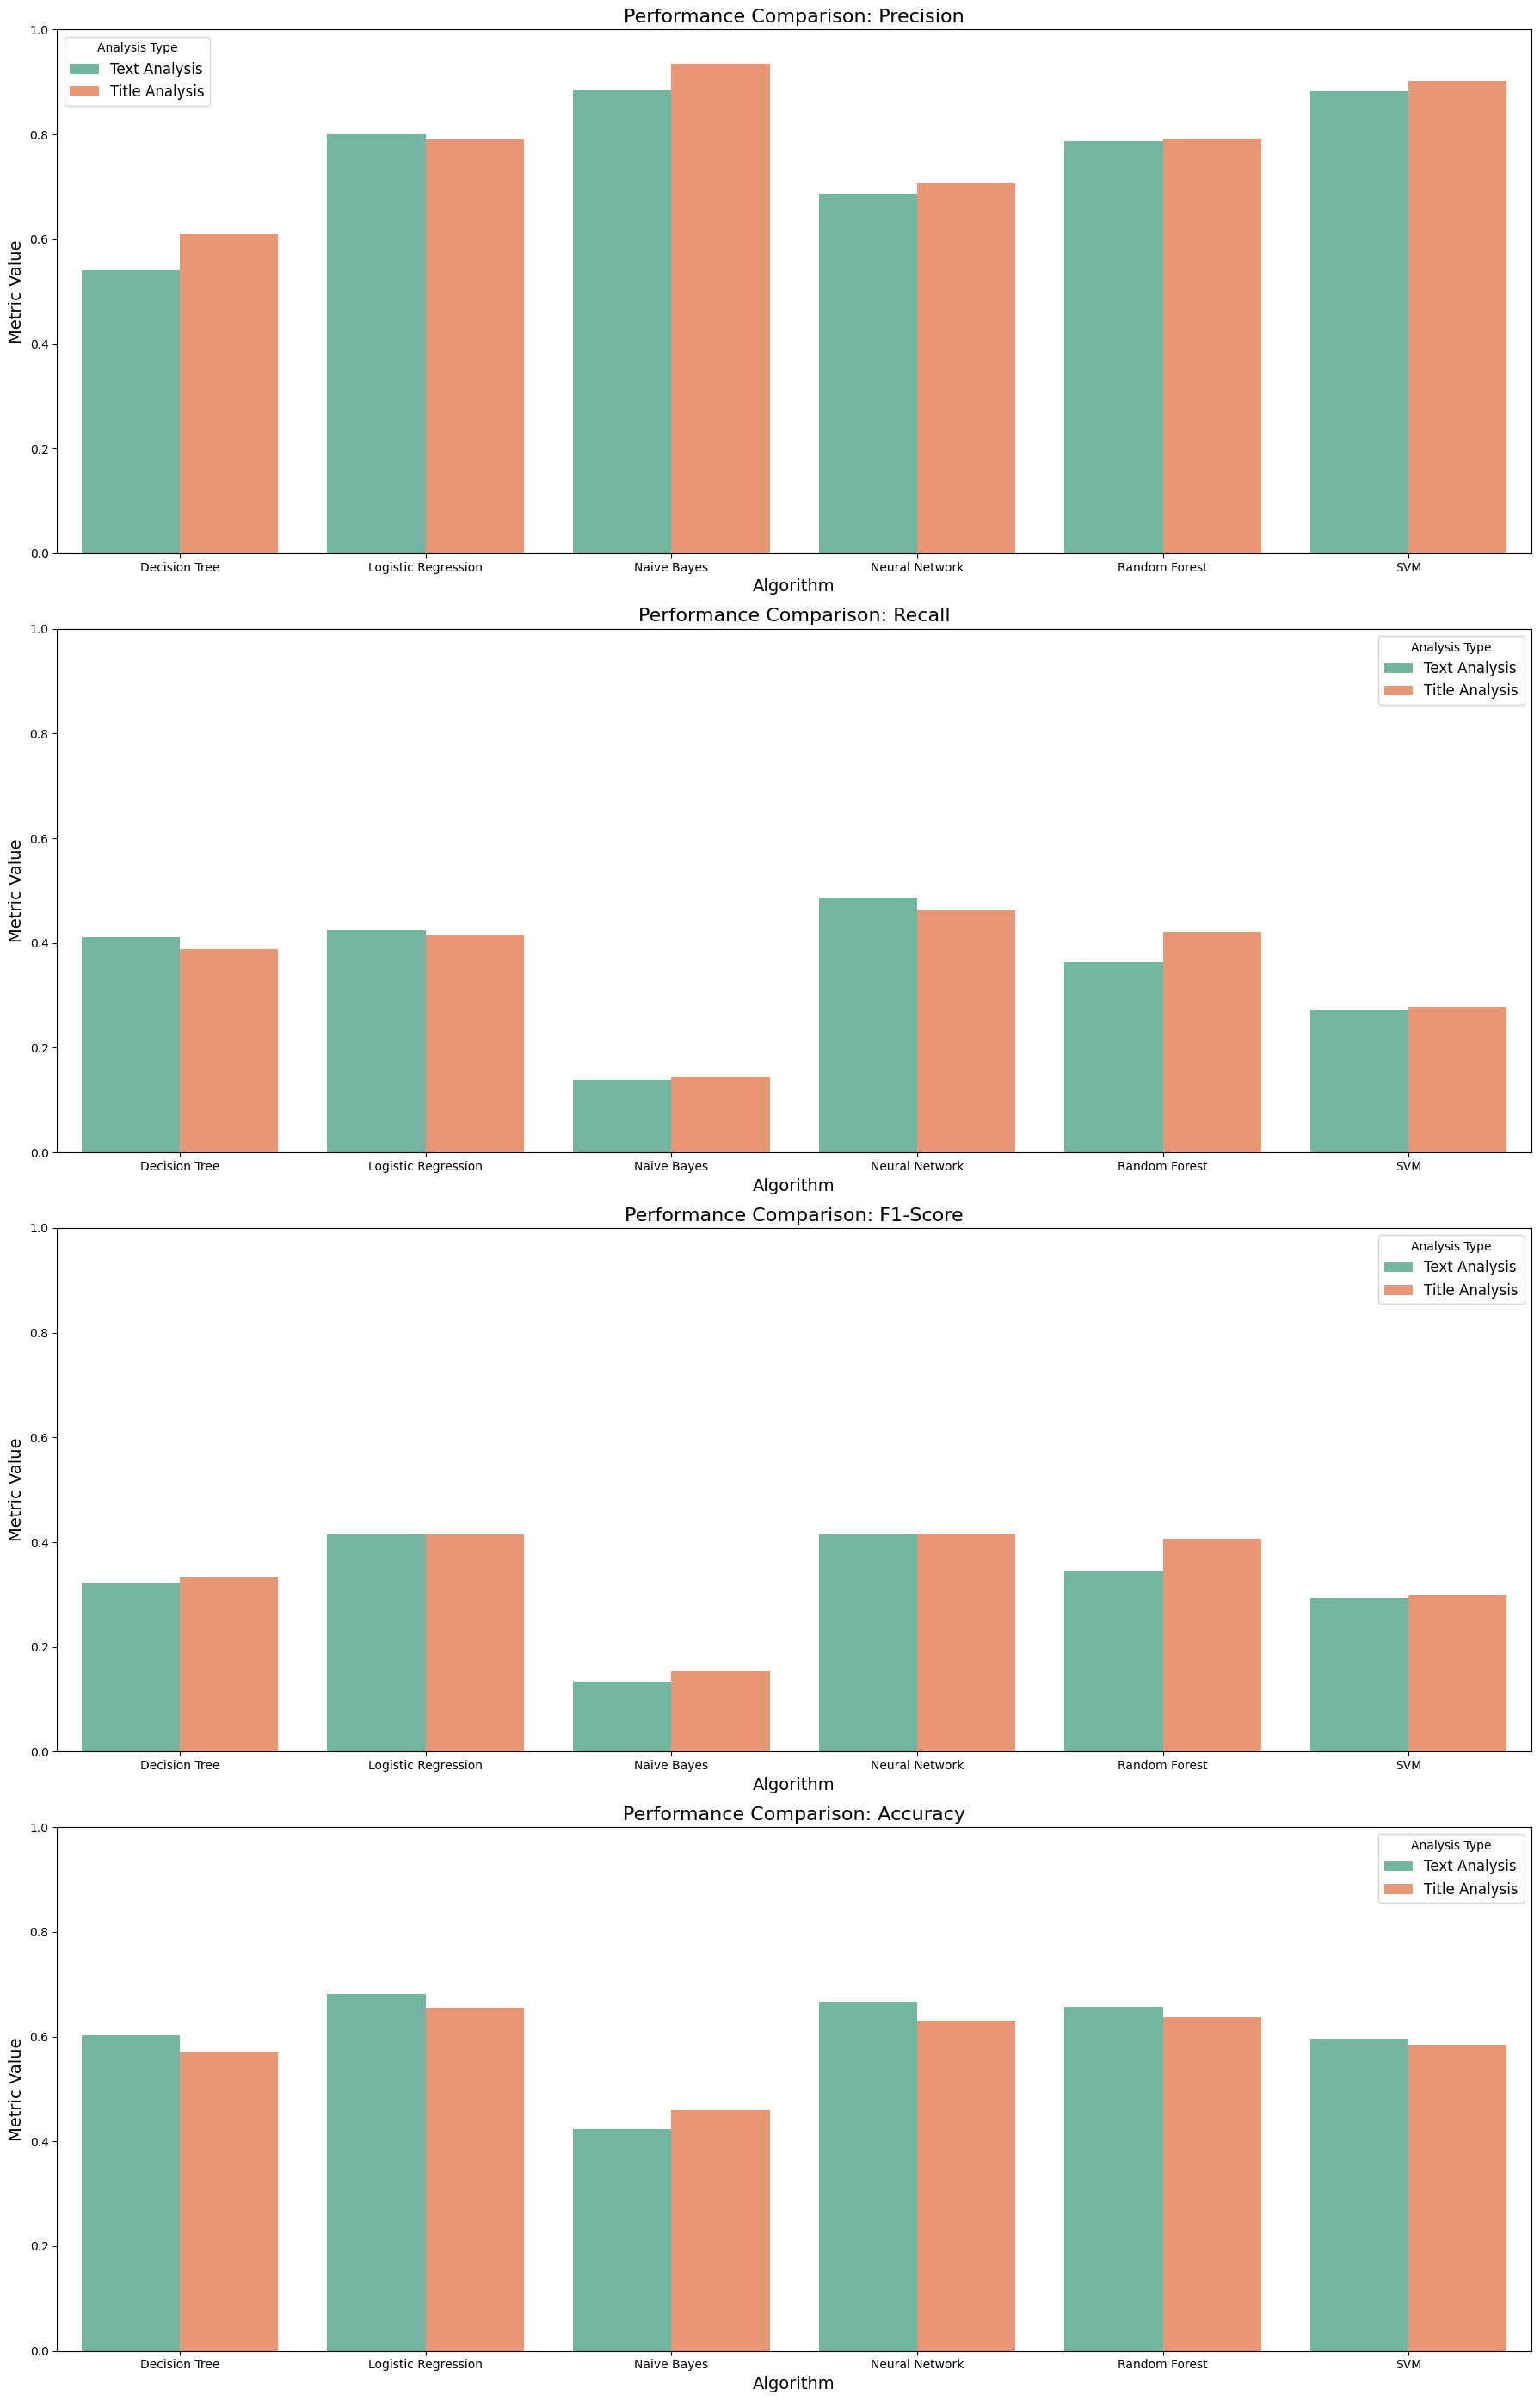

In [81]:
def plot_combined_metrics(combined_classification_pivot, combined_accuracy_pivot, categories):
    
    # Convert combined classification pivot to long format
    combined_classification_long = combined_classification_pivot.reset_index().melt(
        id_vars=['Algorithm', 'Analysis'], 
        var_name='Metric_Target', 
        value_name='Value'
    )
    combined_classification_long[['Metric', 'Target']] = combined_classification_long['Metric_Target'].str.split('_', expand=True)
    combined_classification_long = combined_classification_long.drop(columns='Metric_Target')

    # Convert combined accuracy pivot to long format
    combined_accuracy_long = combined_accuracy_pivot.reset_index().melt(
        id_vars=['Algorithm', 'Analysis'], 
        var_name='Target', 
        value_name='Value'
    )
    combined_accuracy_long['Metric'] = 'Accuracy'

    # Combine classification and accuracy metrics
    combined_metrics = pd.concat([combined_classification_long, combined_accuracy_long])

    # Plotting
    fig, axes = plt.subplots(4, 1, figsize=(18, 28))  # One row for each metric
    metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']

    for i, metric in enumerate(metrics):
        # Filter data for the current metric
        data = combined_metrics[combined_metrics['Metric'] == metric]

        # Plotting
        sns.barplot(
            data=data, 
            x="Algorithm", 
            y="Value", 
            hue="Analysis", 
            ax=axes[i], 
            palette="Set2",
            errorbar=None  # Disable error bars
        )

        axes[i].set_title(f"Performance Comparison: {metric}", fontsize=16)
        axes[i].set_xlabel("Algorithm", fontsize=14)
        axes[i].set_ylabel("Metric Value", fontsize=14)
        axes[i].legend(title="Analysis Type", fontsize=12)
        axes[i].set_ylim(0, 1)  # Metrics are between 0 and 1

    plt.tight_layout()
    plt.show()


# Define the categories for plotting
categories = ["hazard-category", "product-category", "hazard", "product"]

# Plot combined metrics for comparison
plot_combined_metrics(combined_classification_pivot, combined_accuracy_pivot, categories)